# Running experiments for our local calibration method

In [5]:
import os
import time
from os import path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nonconformist.cp import IcpRegressor
from nonconformist.nc import NcFactory
from sklearn.ensemble import RandomForestRegressor

from lcv.cqr import ConformalizedQuantileRegression
from lcv.locart import LocalRegressionSplit, LocartSplit
from lcv.locluster import KmeansSplit
from lcv.models import QuantileGradientBoosting
from lcv.scores import RegressionScore, QuantileScore
from lcv.simulation import simulation
from lcv.utils import compute_interval_length, real_coverage, split

original_path = os.getcwd()

# figure path
images_dir = "figures"

## Simulated datasets

We will also need to compute conditional and real coverage. For that, we can compute coverage with the following function:

In [3]:
# methods to compute coverage
def real_coverage(model_preds, y_mat):
    r = np.zeros(model_preds.shape[0])
    for i in range(model_preds.shape[0]):
        r[i] = np.mean(np.logical_and(y_mat[i,:] >= model_preds[i, 0], y_mat[i, :] <= model_preds[i, 1]))
    return r

def locart_coverage(locart_model, X_grid, y_mat):
    r = np.zeros(X_grid.shape[0])
    for i in range(X_grid.shape[0]):
        new_X = np.tile(X_grid[i, :], (y_mat.shape[1], 1))
        r[i] = np.unique(locart_model.predict_coverage(new_X, y_mat[i, :], marginal = False)) 
    return r

def uniform_coverage(locart_model, X_grid, y_mat):
    r = np.zeros(X_grid.shape[0])
    for i in range(X_grid.shape[0]):
        new_X = np.tile(X_grid[i, :], (y_mat.shape[1], 1))
        # marginal
        r[i] = np.unique(locart_model.predict_coverage_uniform(new_X, y_mat[i, :], marginal = False))
        
    return r

# methods to compute interval length
def compute_interval_length(predictions):
    return(predictions[:, 1] - predictions[:, 0])

Testing our pruning approach versus other decision trees regarding conditional coverage:

In [4]:
def test_pruning(kind = "homoscedastic", 
           n = 10000,
           d = 20, 
           coef = 2,
           hetero_value = 1, 
           asym_value = 0.6,
           random_seed = 750,
           sig = 0.05,
           B_x = 4000,
           B_y = 1000,
           grid_min_samples = np.array([100, 500, 1000, 1500, 2000]),
           type_score = "regression",
           base_model = RandomForestRegressor,
           split_calib = False,
           **kwargs):
    # simulating data and then splitting into train and calibration sets
    sim_obj = simulation(dim = d, coef = coef, hetero_value = hetero_value, asym_value = asym_value)
    sim_kind = getattr(sim_obj, kind)
    sim_kind(n, random_seed = random_seed)
    split_icp = split(sim_obj.X, sim_obj.y, test_size = 0.5, calibrate = False)

    # coverage plot elements
    # generating X's features from uniform
    X_test = np.random.uniform(low = -1.5, high = 1.5, size = (B_x, d))
    
    # simulating several y from same X
    r_kind = getattr(sim_obj, kind + "_r")
    y_mat = r_kind(X_test[:, 0], B = B_y)
    
    if type_score == "regression":
        # fitting pruning locart
        locart_prune = LocartSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
        locart_prune.fit(split_icp["X_train"], split_icp["y_train"])
        locart_prune.calib(split_icp["X_test"], split_icp["y_test"])

         # conditional coverage and interval length
        pred_locart = np.array(locart_prune.predict(X_test, length = 2000))
        cond_locart_real =  real_coverage(pred_locart, y_mat)
        locart_interval_len = compute_interval_length(pred_locart)

        # several measures
        locart_ave_dist = np.mean(np.abs(cond_locart_real - (1 - sig)))
        locart_med_cover = np.median(cond_locart_real)
        locart_med_dist = np.median(np.abs(cond_locart_real - (1 - sig)))
        locart_ave_marginal_cov = np.mean(cond_locart_real)
        locart_interval = np.mean(locart_interval_len)

        # list of locart models 
        dist_list = [locart_ave_dist]
        med_coverage_list = [locart_med_cover]
        med_dist_list = [locart_med_dist]
        marg_coverage_list = [locart_ave_marginal_cov]
        int_length_list = [locart_interval]
        methods_names = ["Pruned tree"]

        for min_samples_leaf in grid_min_samples:
            locart = LocartSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
            locart.fit(split_icp["X_train"], split_icp["y_train"])
            locart.calib(split_icp["X_test"], split_icp["y_test"], prune_tree = False, min_samples_leaf = min_samples_leaf)
            # computing coverage
            # conditional coverage and interval length
            pred_locart = np.array(locart.predict(X_test, length = 2000))
            cond_coverage=  real_coverage(pred_locart, y_mat)
            locart_interval_len = compute_interval_length(pred_locart)

            # computing metrics
            dist_list.append(np.mean(np.abs(cond_coverage - (1 - sig))))
            marg_coverage_list.append(np.mean(cond_coverage))
            med_coverage_list.append(np.median(cond_coverage))
            med_dist_list.append(np.median(np.abs(cond_coverage - (1 - sig))))
            int_length_list.append(np.mean(locart_interval_len))


            methods_names.append("leafs = " + str(min_samples_leaf))
        
        return pd.DataFrame(data = {"Methods":methods_names,
        "Average distance":dist_list,
        "Average marginal coverage": marg_coverage_list,
        "Average interval length": int_length_list,
        "Median conditional coverage": med_coverage_list,
        "Median distance": med_dist_list})

Analysing coverage for different distributions and CART models: 

Homoscedastic:

In [31]:
test_pruning()

,Methods,Average conditional coverage,Average distance,Average marginal coverage,Average interval length,Median conditional coverage,Median distance
0,Pruned tree,0.949139,0.007975,0.949139,3.995778,0.951,0.006
1,leafs = 100,0.990445,0.040445,0.990445,3.898237,0.991,0.041
2,leafs = 500,0.961198,0.012869,0.961198,3.963129,0.963,0.013
3,leafs = 1000,0.952905,0.008397,0.952905,3.998215,0.954,0.007
4,leafs = 1500,0.950828,0.008020,0.950828,3.981904,0.952,0.006
5,leafs = 2000,0.953681,0.008825,0.953681,3.988737,0.955,0.008


Heteroscedastisc

In [32]:
test_pruning(kind = "heteroscedastic", hetero_value=0.15)

,Methods,Average conditional coverage,Average distance,Average marginal coverage,Average interval length,Median conditional coverage,Median distance
0,Pruned tree,0.974418,0.032130,0.974418,4.935242,0.984,0.036
1,leafs = 100,0.982507,0.034229,0.982507,4.785485,0.990,0.040
2,leafs = 500,0.975229,0.032094,0.975229,4.929516,0.984,0.036
3,leafs = 1000,0.960660,0.034701,0.960661,4.959803,0.971,0.038
4,leafs = 1500,0.962742,0.034092,0.962742,5.044207,0.973,0.038
5,leafs = 2000,0.955386,0.036974,0.955386,5.287756,0.965,0.040


Highly heteroscedastic:

In [33]:
test_pruning(kind = "heteroscedastic", hetero_value = 1.5)

,Methods,Average conditional coverage,Average distance,Average marginal coverage,Average interval length,Median conditional coverage,Median distance
0,Pruned tree,0.958950,0.025066,0.958950,6.824819,0.963,0.025
1,leafs = 100,0.984262,0.034471,0.984262,6.555294,0.987,0.037
2,leafs = 500,0.967131,0.024972,0.967131,6.787877,0.971,0.024
3,leafs = 1000,0.959009,0.025116,0.959009,6.791946,0.962,0.025
4,leafs = 1500,0.958704,0.025238,0.958704,6.869702,0.963,0.025
5,leafs = 2000,0.954329,0.026072,0.954329,6.889447,0.958,0.026


Asymmetric:

In [34]:
test_pruning(kind = "asymmetric", asym_value = 0.6)

,Methods,Average conditional coverage,Average distance,Average marginal coverage,Average interval length,Median conditional coverage,Median distance
0,Pruned tree,0.966765,0.026485,0.966765,6.928806,0.973,0.027
1,leafs = 100,0.971221,0.027413,0.971221,6.788606,0.977,0.028
2,leafs = 500,0.971555,0.027892,0.971556,7.020521,0.977,0.029
3,leafs = 1000,0.967439,0.026748,0.967439,6.966743,0.974,0.027
4,leafs = 1500,0.964251,0.026331,0.964251,7.145932,0.971,0.026
5,leafs = 2000,0.957838,0.026620,0.957838,7.310045,0.965,0.025


Highly asymmetric:

In [35]:
test_pruning(kind = "asymmetric", asym_value = 1.6)

KeyboardInterrupt: 

We also analyse the efficiency of splitting locart tree:

In [ ]:
test_pruning(split_calib = True)

,Methods,Average conditional coverage,Average distance,Average marginal coverage,Average interval length
0,Pruned tree,0.950320,0.009859,0.950320,4.002628
1,leafs = 100,0.928361,0.022044,0.928361,4.018390
2,leafs = 500,0.948185,0.009877,0.948185,3.973476
3,leafs = 1000,0.951646,0.009825,0.951646,3.956951
4,leafs = 1500,0.948069,0.009816,0.948069,3.962286
5,leafs = 2000,0.950452,0.009755,0.950452,4.008328


In [ ]:
test_pruning(split_calib = True, kind = "heteroscedastic", hetero_value=0.15)

,Methods,Average conditional coverage,Average distance,Average marginal coverage,Average interval length
0,Pruned tree,0.970672,0.030356,0.970672,5.584821
1,leafs = 100,0.984912,0.035577,0.984912,5.473791
2,leafs = 500,0.970193,0.030571,0.970193,5.573654
3,leafs = 1000,0.948784,0.036820,0.948784,5.882360
4,leafs = 1500,0.951207,0.035432,0.951207,5.834823
5,leafs = 2000,0.951506,0.035509,0.951506,5.855645


In [ ]:
test_pruning(split_calib = True, kind = "heteroscedastic", hetero_value = 1.5)

In [ ]:
test_pruning(split_calib = True, kind = "asymmetric", asym_value = 0.6)

In [ ]:
test_pruning(split_calib = True, kind = "asymmetric", asym_value = 1.6)

We will first compare our method to other conformal and non conformal methods using $S(\boldsymbol{x}, y) = |g(\boldsymbol{x}) - y|$ (Regression score) as our non conformity score:

### Regression Score

Here we will focus in comparing the regression conformal methods with our method on homoscedastisc, heteroscedastic and asymmetric data with noise. Our method returns diferent thresholds for $t(x)$ while the two commonly used weighted regression and regression split retuns a single threshold $t$. In order to compare these approaches, we define the following functions:

In [31]:
def compute_conformal_statistics(kind = "homoscedastic", 
           n = 20000,
           d = 20, 
           coef = 2,
           hetero_value = 1,
           asym_value = 0.6,
           t_degree = 4,
           random_seed = 1250, 
           sig = 0.05,
           alpha = 0.5,
           B_x = 4000,
           B_y = 1000,
           type_score = "regression",
           base_model = RandomForestRegressor,
           figname_tree = "locart_tree.pdf",
           only_locart = False,
           split_calib = False,
           plot_tree = True,
           n_estimators = 200,
           quantiles = [0.8, 0.85, 0.9, 0.95],
           random_states = [750, 85, 666, 69],
           prop_k = np.arange(2, 11),
           tune_k = True,
           criterion = "squared_error",
           max_depth = None,
           max_leaf_nodes = None,
           min_samples_leaf = 300,
           prune = True,
           **kwargs):
    # generating X's features from uniform
    X_test = np.random.uniform(low = -1.5, high = 1.5, size = (B_x, d))
           
    # simulating data and then splitting into train and calibration sets
    sim_obj = simulation(dim = d, coef = coef, hetero_value = hetero_value, asym_value = asym_value, t_degree = t_degree)
    sim_kind = getattr(sim_obj, kind)
    sim_kind(n, random_seed = random_seed)
    split_icp = split(sim_obj.X, sim_obj.y, test_size = 0.5,calibrate = False)

    # coverage plot elements
    
    # simulating several y from same X
    r_kind = getattr(sim_obj, kind + "_r")
    y_mat = r_kind(X_test[:, 0], B = B_y)
    
    if type_score == "regression":
        if only_locart:
            # fitting locart
            locart_obj = LocartSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
            locart_obj.fit(split_icp["X_train"], split_icp["y_train"])
            locart_obj.calib(split_icp["X_test"], split_icp["y_test"], max_depth = max_depth, 
            max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune)

            # conditional coverage and interval length
            pred_locart = np.array(locart_obj.predict(X_test, length = 2000))
            cond_locart_real =  real_coverage(pred_locart, y_mat)
            locart_interval_len = compute_interval_length(pred_locart)

            # several measures
            locart_ave_dist = np.mean(np.abs(cond_locart_real - (1 - sig)))
            locart_med_cover = np.median(cond_locart_real)
            locart_med_dist = np.median(np.abs(cond_locart_real - (1 - sig)))
            locart_ave_marginal_cov = np.mean(cond_locart_real)
            locart_interval = np.mean(locart_interval_len)

            all_results =  pd.DataFrame(data = {"Methods":["LOCART"],
                "Average distance":[locart_ave_dist],
                "Median conditional coverage":[locart_med_cover],
                "Median distance":[locart_med_dist],
                "Average marginal coverage":[locart_ave_marginal_cov],
                "Average interval length":[locart_interval]})

            # plotting boxplots
            # gathering all data into a data frame
            boxplot_data = pd.melt(pd.DataFrame(data = {"Methods":list(np.repeat(["LOCART"], locart_interval_len.shape[0])),
                                            "Interval length": list(locart_interval_len),
                                            "Coverage": list(cond_locart_real)}), id_vars = ['Methods'], 
                                            value_vars = ['Interval length', 'Coverage'])

            plt.figure(figsize=(10, 6))
            sns.catplot(data = boxplot_data,
            y = 'Methods', x = 'value', col = 'variable', kind = 'box', sharex= False)
            plt.tight_layout()
            plt.show()

            # plotting tree to visualize partitions
            if plot_tree:
                plt.figure(figsize=(25, 20))
                locart_obj.plot_locart()
                plt.savefig(f"{images_dir}/{figname_tree}")
                plt.show()
            
            return [all_results, locart_obj]
        
        print("Fitting locluster")
        start_locluster = time.time()
        locluster_obj = KmeansSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, **kwargs)
        locluster_obj.fit(split_icp["X_train"], split_icp["y_train"])
        locluster_obj.calib(split_icp["X_test"], split_icp["y_test"], tune_k = tune_k, 
        prop_k = prop_k, n_estimators = n_estimators, quantiles = quantiles, random_states = random_states)

        end_locluster = time.time()

        print("Computing metrics")
        start_locluster = time.time()
        # conditional coverage and interval length
        pred_locluster = np.array(locluster_obj.predict(X_test, length = 2000))
        cond_locluster_real =  real_coverage(pred_locluster, y_mat)
        locluster_interval_len = compute_interval_length(pred_locluster)

        # several measures
        locluster_ave_dist = np.mean(np.abs(cond_locluster_real - (1 - sig)))
        locluster_med_cover = np.median(cond_locluster_real)
        locluster_med_dist = np.median(np.abs(cond_locluster_real - (1 - sig)))
        locluster_ave_marginal_cov = np.mean(cond_locluster_real)
        locluster_interval = np.mean(locluster_interval_len)

        end_locluster = time.time() - start_locluster
        print("Time Elapsed to compute metrics for Locluster: ", end_locluster)


        print("Fitting locart")
        start_loc = time.time()
        # fitting locart
        locart_obj = LocartSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
        locart_obj.fit(split_icp["X_train"], split_icp["y_train"])
        locart_obj.calib(split_icp["X_test"], split_icp["y_test"], max_depth = max_depth, 
        max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune)
        
        end_loc = time.time() - start_loc
        print("Time Elapsed to fit Locart: ", end_loc)

        print("Computing metrics")
        start_loc = time.time()
        # conditional coverage and interval length
        pred_locart = np.array(locart_obj.predict(X_test, length = 2000))
        cond_locart_real =  real_coverage(pred_locart, y_mat)
        locart_interval_len = compute_interval_length(pred_locart)

        # several measures
        locart_ave_dist = np.mean(np.abs(cond_locart_real - (1 - sig)))
        locart_med_cover = np.median(cond_locart_real)
        locart_med_dist = np.median(np.abs(cond_locart_real - (1 - sig)))
        locart_ave_marginal_cov = np.mean(cond_locart_real)
        locart_interval = np.mean(locart_interval_len)
        end_loc = time.time() - start_loc
        print("Time Elapsed to compute metrics for Locart: ", end_loc)

        # fitting default regression split
        print("Fitting regression split")
        start_split = time.time()
        model = base_model(**kwargs)
        nc = NcFactory.create_nc(model)
        icp = IcpRegressor(nc)
        icp.fit(split_icp["X_train"], split_icp["y_train"])
        icp.calibrate(split_icp["X_test"], split_icp["y_test"])

        end_split = time.time() - start_split
        print("Time Elapsed to fit regression split: ", end_split)

        print("Computing metrics")
        start_split = time.time()
        # icp real coverage and interval length
        icp_cond_r_real = real_coverage(icp.predict(X_test, significance = sig), y_mat)
        icp_interval_len = compute_interval_length(icp.predict(X_test, significance = sig))

        # computing icp measures
        icp_ave_dist = np.mean(np.abs(icp_cond_r_real - (1 - sig)))
        icp_ave_marginal_cov = np.mean(icp_cond_r_real)
        icp_med_cover = np.median(icp_cond_r_real)
        icp_med_dist = np.median(np.abs(icp_cond_r_real - (1 - sig)))
        icp_interval = np.mean(icp_interval_len)

        end_split = time.time() - start_split
        print("Time Elapsed to compute statistics for regression split: ", end_split)

        # fitting wighted regression split
        print("Fitting weighted regression split")
        start_weighted_split = time.time()
        wicp = LocalRegressionSplit(base_model, alpha = sig, **kwargs)
        wicp.fit(split_icp["X_train"], split_icp["y_train"])
        wicp.calibrate(split_icp["X_test"], split_icp["y_test"])

        end_weighted_split = time.time() - start_weighted_split
        print("Time Elapsed to fit weighted regression split: ", end_weighted_split)

        print("Computing metrics")
        start_weighted_split = time.time()
        # weighted icp real coverage and interval length
        wicp_cond_r_real = real_coverage(wicp.predict(X_test), y_mat)
        wicp_interval_len = compute_interval_length(wicp.predict(X_test))

        # computing wicp measures
        wicp_ave_dist = np.mean(np.abs(wicp_cond_r_real - (1 - sig)))
        wicp_ave_marginal_cov = np.mean(wicp_cond_r_real)
        wicp_med_cover = np.median(wicp_cond_r_real)
        wicp_med_dist = np.median(np.abs(wicp_cond_r_real - (1 - sig)))
        wicp_interval = np.mean(wicp_interval_len)

        end_weighted_split = time.time() - start_weighted_split
        print("Time Elapsed to compute statistics for weighted regression split: ", end_weighted_split)


        print("Fitting euclidean regression split")
        start_euclidean = time.time()
        # fitting uniform binning regression split
        locart_obj.uniform_binning(split_icp["X_test"], split_icp["y_test"])
        end_euclidean = time.time() - start_euclidean
        print("Time Elapsed to fit euclidean regression split: ", end_euclidean)

        # computing local coverage to uniform binning
        print("Computing metrics")
        start_euclidean = time.time()
        pred_uniform = np.array(locart_obj.predict(X_test, length = 2000, type_model = "euclidean"))
        uniform_cond_r_real = real_coverage(pred_uniform, y_mat)
        uniform_interval_len = compute_interval_length(pred_uniform)

        # computing euclidean binning measures
        uniform_ave_dist = np.mean(np.abs(uniform_cond_r_real - (1 - sig)))
        uniform_ave_marginal_cov = np.mean(uniform_cond_r_real)
        uniform_med_cover = np.median(uniform_cond_r_real)
        uniform_med_dist = np.median(np.abs(uniform_cond_r_real - (1 - sig)))
        uniform_interval = np.mean(uniform_interval_len)

        end_euclidean = time.time() - start_euclidean
        print("Time Elapsed to compute statistics for euclidean regression split: ", end_euclidean)

        
        all_results =  pd.DataFrame(data = {"Methods":["LOCLUSTER", "LOCART", "Regresion split", "Weighted regression split", "Euclidean regression split"],
        "Average distance":[locluster_ave_dist, locart_ave_dist,  icp_ave_dist, wicp_ave_dist, uniform_ave_dist],
        "Median conditional coverage":[locluster_med_cover, locart_med_cover, icp_med_cover, wicp_med_cover, uniform_med_cover],
        "Median distance":[locluster_med_dist, locart_med_dist, icp_med_dist, wicp_med_dist, uniform_med_dist],
        "Average marginal coverage":[locluster_ave_marginal_cov, locart_ave_marginal_cov, icp_ave_marginal_cov, wicp_ave_marginal_cov, uniform_ave_marginal_cov],
        "Average interval length":[locluster_interval, locart_interval, icp_interval, wicp_interval, uniform_interval]})

        # plotting boxplots
        # gathering all data into a data frame
        boxplot_data = pd.melt(pd.DataFrame(data = {"Methods":list(np.repeat(["LOCLUSTER", "LOCART", "Regresion split", 
        "Weighted regression split", "Euclidean regression split"],
        locart_interval_len.shape[0])),
        "Interval length": list(np.concatenate((locluster_interval_len, locart_interval_len, icp_interval_len, wicp_interval_len, uniform_interval_len))),
        "Coverage": list(np.concatenate((cond_locluster_real, cond_locart_real, icp_cond_r_real, wicp_cond_r_real, uniform_cond_r_real)))
        }), id_vars = ['Methods'], value_vars = ['Interval length', 'Coverage'])

        plt.figure(figsize=(10, 6))
        sns.catplot(data = boxplot_data,
        y = 'Methods', x = 'value', col = 'variable', kind = 'box', sharex= False)
        plt.tight_layout()
        plt.show()
    
    elif type_score == "quantile":
        # fitting gradient boosting quantile regression
        # first fitting quantile split
        model = base_model(alpha = sig, **kwargs)
        cqr = ConformalizedQuantileRegression(model, alpha = sig)
        cqr.fit(split_icp["X_train"], split_icp["y_train"])
        cqr.calib(split_icp["X_test"], split_icp["y_test"])
        
        # icp real coverage and interval length
        pred_cqr = cqr.predict(X_test)
        cqr_cond_r_real = real_coverage(pred_cqr, y_mat)
        cqr_interval_len = compute_interval_length(pred_cqr)

        # computing icp measures
        cqr_ave_dist = np.mean(np.abs(cqr_cond_r_real - (1 - sig)))
        cqr_ave_marginal_cov = np.mean(cqr_cond_r_real)
        cqr_med_cover = np.median(cqr_cond_r_real)
        cqr_med_dist = np.median(np.abs(cqr_cond_r_real - (1 - sig)))
        cqr_interval = np.mean(cqr_interval_len)

        # fitting locluster
        locluster_obj = KmeansSplit(nc_score = QuantileScore, base_model = base_model, alpha = sig, **kwargs)
        locluster_obj.fit(split_icp["X_train"], split_icp["y_train"])
        locluster_obj.calib(split_icp["X_test"], split_icp["y_test"], tune_k = tune_k, 
        prop_k = prop_k, n_estimators = n_estimators, quantiles = quantiles, random_states = random_states)


        # conditional coverage and interval length
        pred_locluster = np.array(locluster_obj.predict(X_test, length = 2000))
        cond_locluster_real =  real_coverage(pred_locluster, y_mat)
        locluster_interval_len = compute_interval_length(pred_locluster)

        # several measures
        locluster_ave_dist = np.mean(np.abs(cond_locluster_real - (1 - sig)))
        locluster_med_cover = np.median(cond_locluster_real)
        locluster_med_dist = np.median(np.abs(cond_locluster_real - (1 - sig)))
        locluster_ave_marginal_cov = np.mean(cond_locluster_real)
        locluster_interval = np.mean(locluster_interval_len)


        # fitting locart
        locart_obj = LocartSplit(nc_score = QuantileScore, base_model = base_model,
        base_model_type=True, alpha = sig, split_calib = split_calib, **kwargs)
        locart_obj.fit(split_icp["X_train"], split_icp["y_train"])
        locart_obj.calib(split_icp["X_test"], split_icp["y_test"], max_depth = max_depth, 
        max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion)

        # conditional coverage and interval length
        pred_locart = locart_obj.predict(X_test, length=2000)
        cond_locart_real = real_coverage(pred_locart, y_mat)
        locart_interval_len = compute_interval_length(pred_locart)
        
        # several measures
        locart_ave_dist = np.mean(np.abs(cond_locart_real - (1 - sig)))
        locart_med_cover = np.median(cond_locart_real)
        locart_med_dist = np.median(np.abs(cond_locart_real - (1 - sig)))
        locart_ave_marginal_cov = np.mean(cond_locart_real)
        locart_interval = np.mean(locart_interval_len)

        # fitting euclidean binning
        locart_obj.uniform_binning(split_icp["X_test"], split_icp["y_test"])

        # computing local coverage to uniform binning
        pred_uniform = locart_obj.predict(
            X_test, length=2000, type_model="euclidean"
        )

        uniform_cond_r_real = real_coverage(pred_uniform, y_mat)
        uniform_interval_len = compute_interval_length(pred_uniform)

        # computing euclidean binning measures
        uniform_ave_dist = np.mean(np.abs(uniform_cond_r_real - (1 - sig)))
        uniform_ave_marginal_cov = np.mean(uniform_cond_r_real)
        uniform_med_cover = np.median(uniform_cond_r_real)
        uniform_med_dist = np.median(np.abs(uniform_cond_r_real - (1 - sig)))
        uniform_interval = np.mean(uniform_interval_len)

        # fitting raw quantilic regression
        qgb_obj = model
        qgb_obj.fit(split_icp["X_train"], split_icp["y_train"])

        pred_qgb = qgb_obj.predict(X_test)
        cond_qgb_real = real_coverage(pred_qgb, y_mat)
        qgb_interval_len = compute_interval_length(pred_qgb)

        # computing raw quantilic measures
        qgb_ave_dist = np.mean(np.abs(cond_qgb_real - (1 - sig)))
        qgb_ave_marginal_cov = np.mean(cond_qgb_real)
        qgb_med_cover = np.median(cond_qgb_real)
        qgb_med_dist = np.median(np.abs(cond_qgb_real - (1 - sig)))
        qgb_interval = np.mean(qgb_interval_len)
    
        
        all_results =  pd.DataFrame(data = {"Methods":["LOCLUSTER", "LOCART", "CQR", "Euclidean CQR", "Quantilic Regression"],
        "Average distance":[locluster_ave_dist, locart_ave_dist, cqr_ave_dist, uniform_ave_dist, qgb_ave_dist],
        "Median conditional coverage":[locluster_med_cover, locart_med_cover, cqr_med_cover, uniform_med_cover, qgb_med_cover],
        "Median distance":[locluster_med_dist, locart_med_dist, cqr_med_dist, uniform_med_dist, qgb_med_dist],
        "Average marginal coverage":[locluster_ave_marginal_cov, locart_ave_marginal_cov, cqr_ave_marginal_cov, uniform_ave_marginal_cov, qgb_ave_marginal_cov],
        "Average interval length":[locluster_interval, locart_interval, cqr_interval, uniform_interval, qgb_interval]})

        # plotting boxplots
        # gathering all data into a data frame
        boxplot_data = pd.melt(pd.DataFrame(data = {"Methods":list(np.repeat(["LOCLUSTER", "LOCART", "CQR", 
        "Euclidean CQR", "Quantilic Regression"],
        locart_interval_len.shape[0])),
        "Interval length": list(np.concatenate((locluster_interval_len, locart_interval_len, cqr_interval_len, uniform_interval_len, qgb_interval_len))),
        "Coverage": list(np.concatenate((cond_locluster_real, cond_locart_real, cqr_cond_r_real, uniform_cond_r_real, cond_qgb_real)))
        }), id_vars = ['Methods'], value_vars = ['Interval length', 'Coverage'])

        plt.figure(figsize=(10, 6))
        sns.catplot(data = boxplot_data,
        y = 'Methods', x = 'value', col = 'variable', kind = 'box', sharex= False)
        plt.tight_layout()
        plt.show()
        
    # plotting tree to visualize partitions
    if plot_tree:
        plt.figure(figsize=(25, 20))
        locart_obj.plot_locart()
        plt.savefig(f"{images_dir}/{figname_tree}")
        plt.show()
    
    return [all_results, locart_obj]

In [6]:
list(np.repeat(["a", "b"], 3))

['a', 'a', 'a', 'b', 'b', 'b']

In [9]:
np.concatenate((np.array([1, 2]), np.array([1])))

array([1, 2, 1])

For now, we will fix $d = 20$, $\beta_1 = 2$ as some of the simulation parameters and vary the distribution of the data to compare our method to the usual split conformal methods, including the euclidean version of them:

### Normal Homoscedastic data:

Fitting locluster
Computing metrics
Time Elapsed to compute metrics for Locluster:  180.94106769561768
Fitting locart
Time Elapsed to fit Locart:  27.940259218215942
Computing metrics
Time Elapsed to compute metrics for Locart:  162.51067185401917
Fitting regression split
Time Elapsed to fit regression split:  30.536574125289917
Computing metrics
Time Elapsed to compute statistics for regression split:  0.8109991550445557
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  52.51150989532471
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  1.9271340370178223
Fitting euclidean regression split
Time Elapsed to fit euclidean regression split:  0.5921318531036377
Computing metrics
Time Elapsed to compute statistics for euclidean regression split:  163.2710280418396


<Figure size 720x432 with 0 Axes>

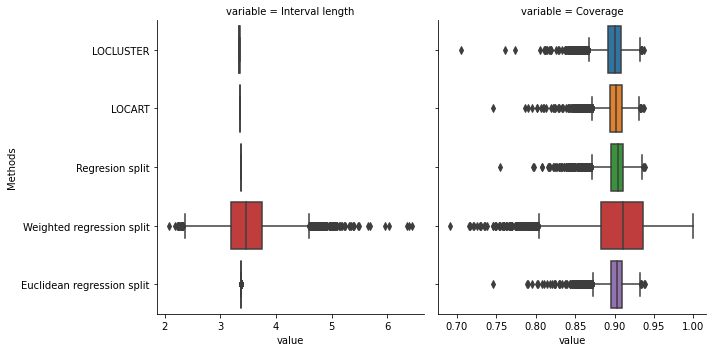

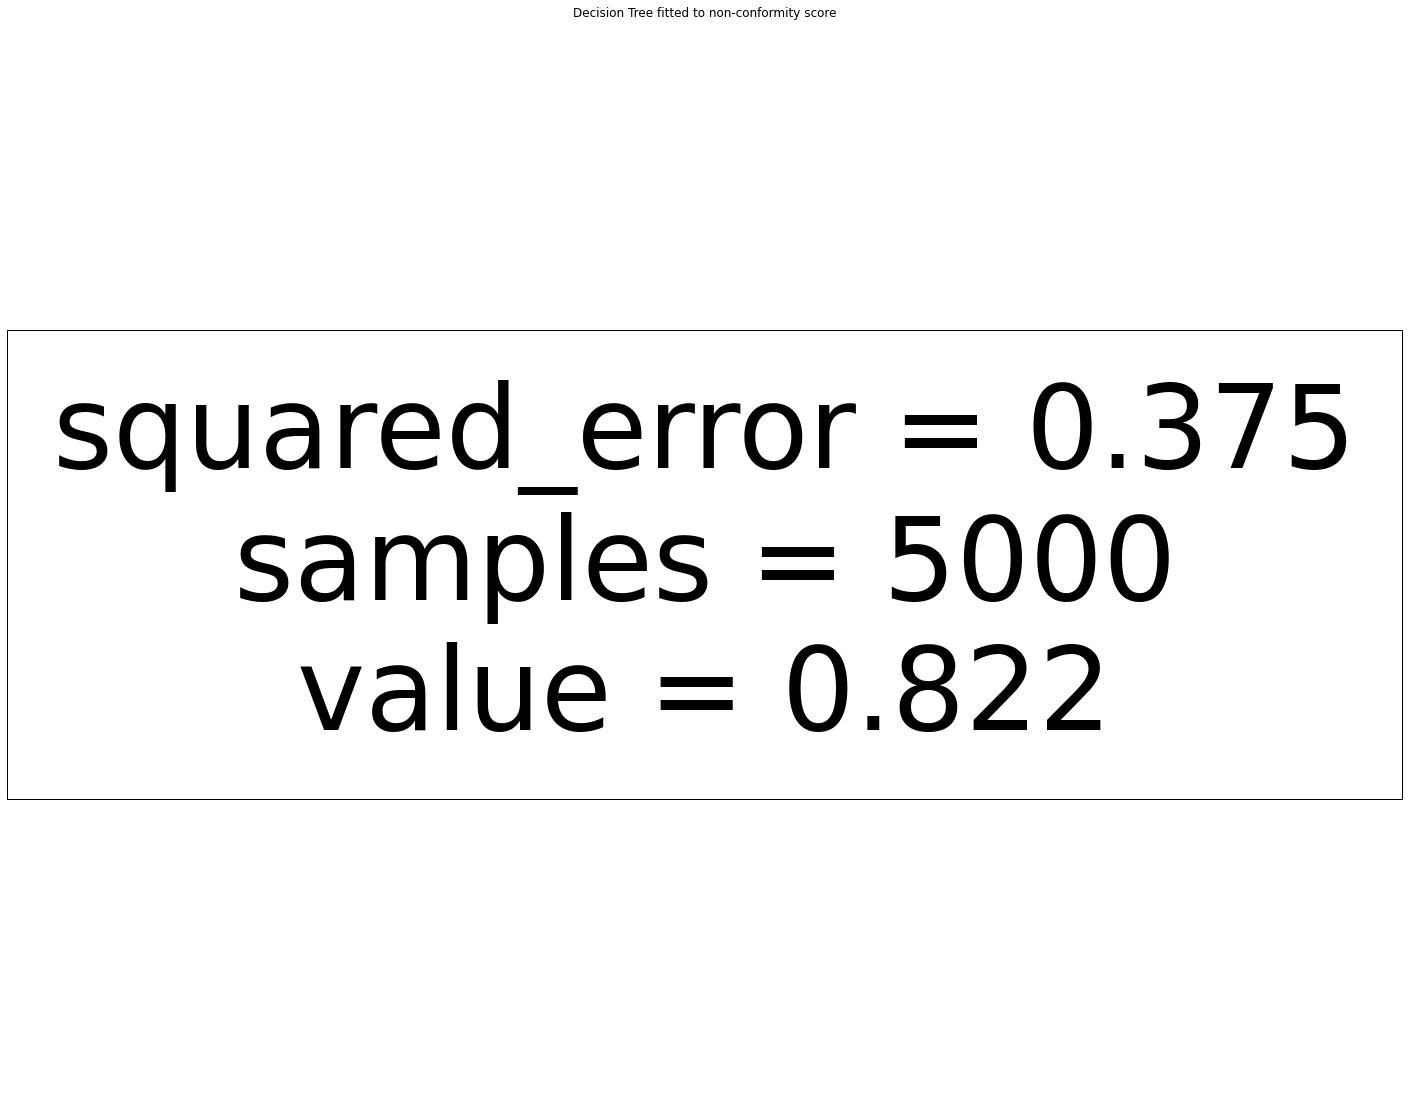

<Figure size 432x288 with 0 Axes>

In [10]:
locart_cov_values = compute_conformal_statistics(figname_tree = "locart_tree_homoscedastic_RF_d_20.pdf",
split_calib = True, B_x = 10000, sig  = 0.1)

In [11]:
locart_cov_values[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.009965,0.901,0.008,0.899196,3.344471
1,LOCART,0.009944,0.902,0.008,0.900482,3.355997
2,Regresion split,0.010238,0.904,0.008,0.902096,3.373200
3,Weighted regression split,0.033375,0.911,0.029,0.906515,3.493964
4,Euclidean regression split,0.010098,0.903,0.008,0.901723,3.368470


### Heteroscedastic data

Taking $\sigma = \sqrt{\gamma + \beta_1 \cdot |X_1|}$ with $\gamma = 0.25$

Fitting locluster
Computing metrics
Time Elapsed to compute metrics for Locluster:  278.42639994621277
Fitting locart
Time Elapsed to fit Locart:  31.819194316864014
Computing metrics
Time Elapsed to compute metrics for Locart:  158.53059434890747
Fitting regression split
Time Elapsed to fit regression split:  29.760910749435425
Computing metrics
Time Elapsed to compute statistics for regression split:  0.7512834072113037
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  45.787240505218506
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  1.7922768592834473
Fitting euclidean regression split
Time Elapsed to fit euclidean regression split:  0.5434832572937012
Computing metrics
Time Elapsed to compute statistics for euclidean regression split:  157.10438919067383


<Figure size 720x432 with 0 Axes>

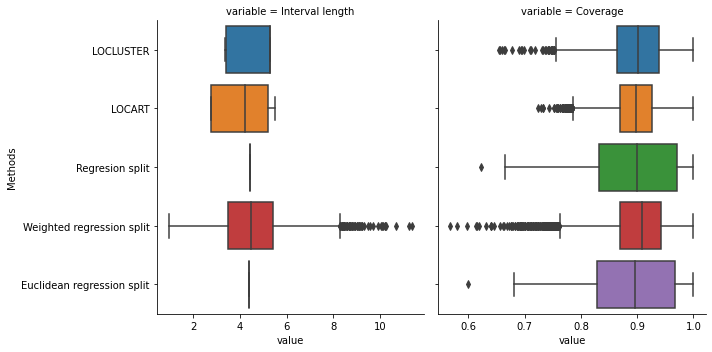

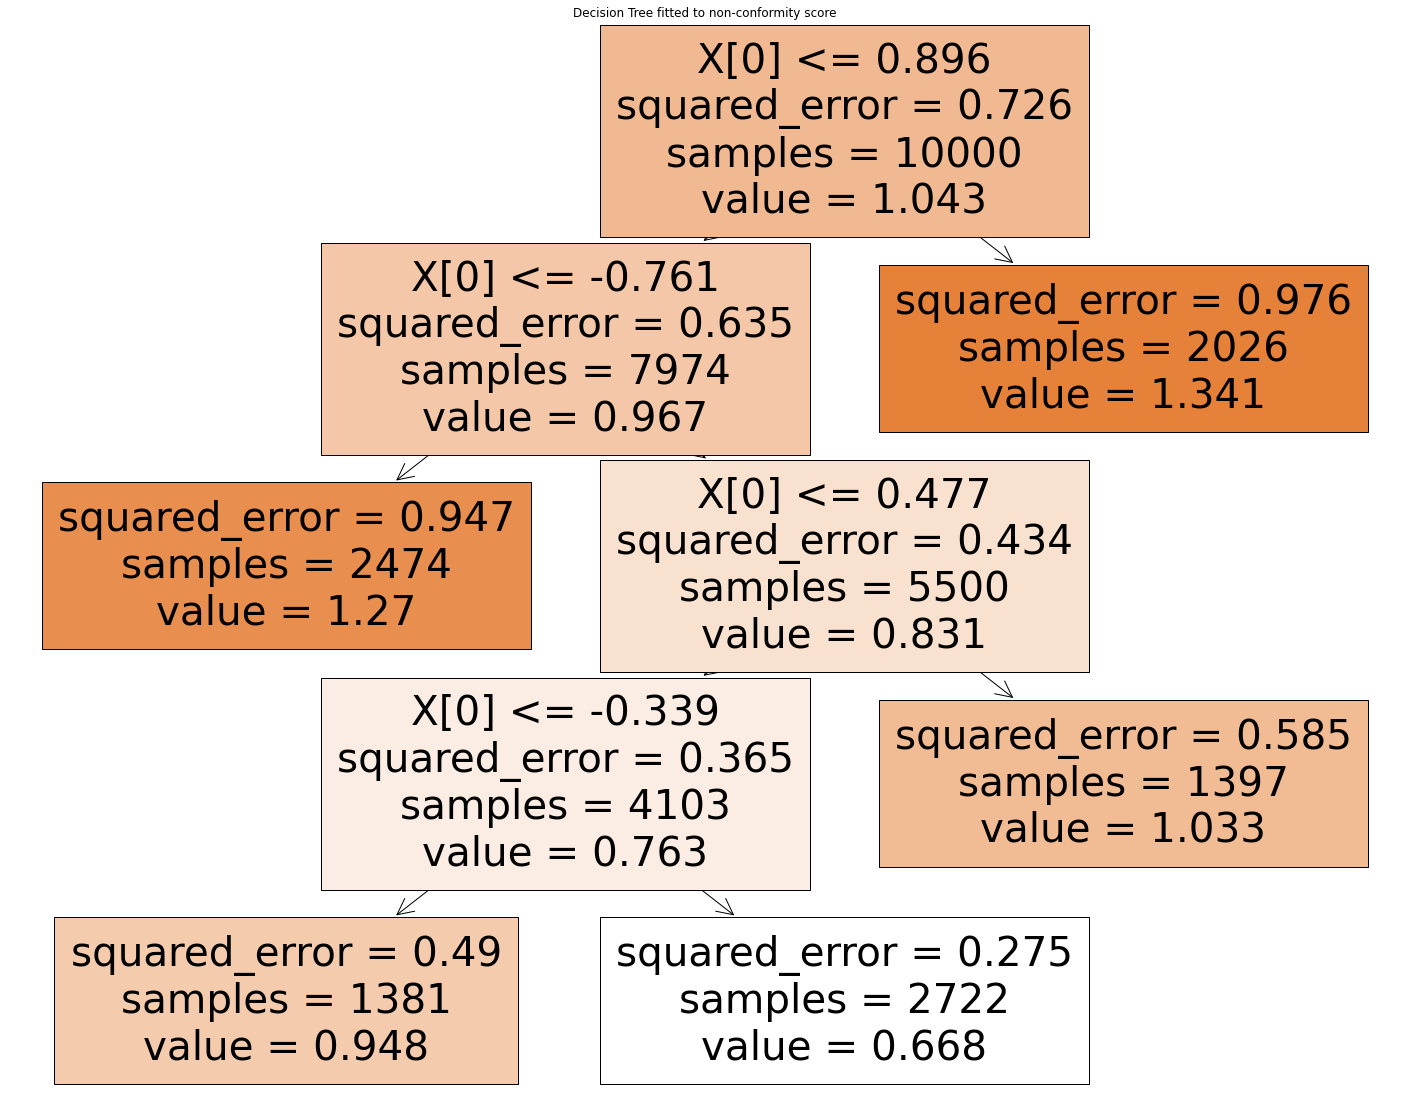

<Figure size 432x288 with 0 Axes>

In [12]:
values = compute_conformal_statistics(kind = "heteroscedastic", d = 20,
figname_tree = "locart_tree_heteroscedastic_RF_d_20_split.pdf", B_x = 10000, split_calib = False,
hetero_value = 0.25, sig = 0.1)

In [13]:
values[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.044028,0.902,0.037,0.900885,4.349362
1,LOCART,0.032926,0.898,0.028,0.897298,4.266651
2,Regresion split,0.065246,0.900,0.068,0.897850,4.434818
3,Weighted regression split,0.043525,0.909,0.037,0.901555,4.450756
4,Euclidean regression split,0.066856,0.896,0.070,0.894196,4.378749


### Asymmetric residuals (gamma)

Taking $\alpha = \beta = 1 + \eta \cdot |X_1|$ for $\eta = 0.7$:

Fitting locluster
Computing metrics
Time Elapsed to compute metrics for Locluster:  260.9598217010498
Fitting locart
Time Elapsed to fit Locart:  39.374120473861694
Computing metrics
Time Elapsed to compute metrics for Locart:  187.6606366634369
Fitting regression split
Time Elapsed to fit regression split:  42.287530183792114
Computing metrics
Time Elapsed to compute statistics for regression split:  0.8783445358276367
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  60.25431275367737
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  1.9938478469848633
Fitting euclidean regression split
Time Elapsed to fit euclidean regression split:  0.6436192989349365
Computing metrics
Time Elapsed to compute statistics for euclidean regression split:  163.52415823936462


<Figure size 720x432 with 0 Axes>

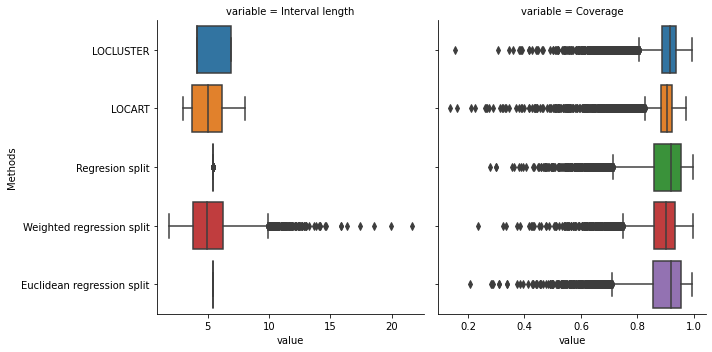

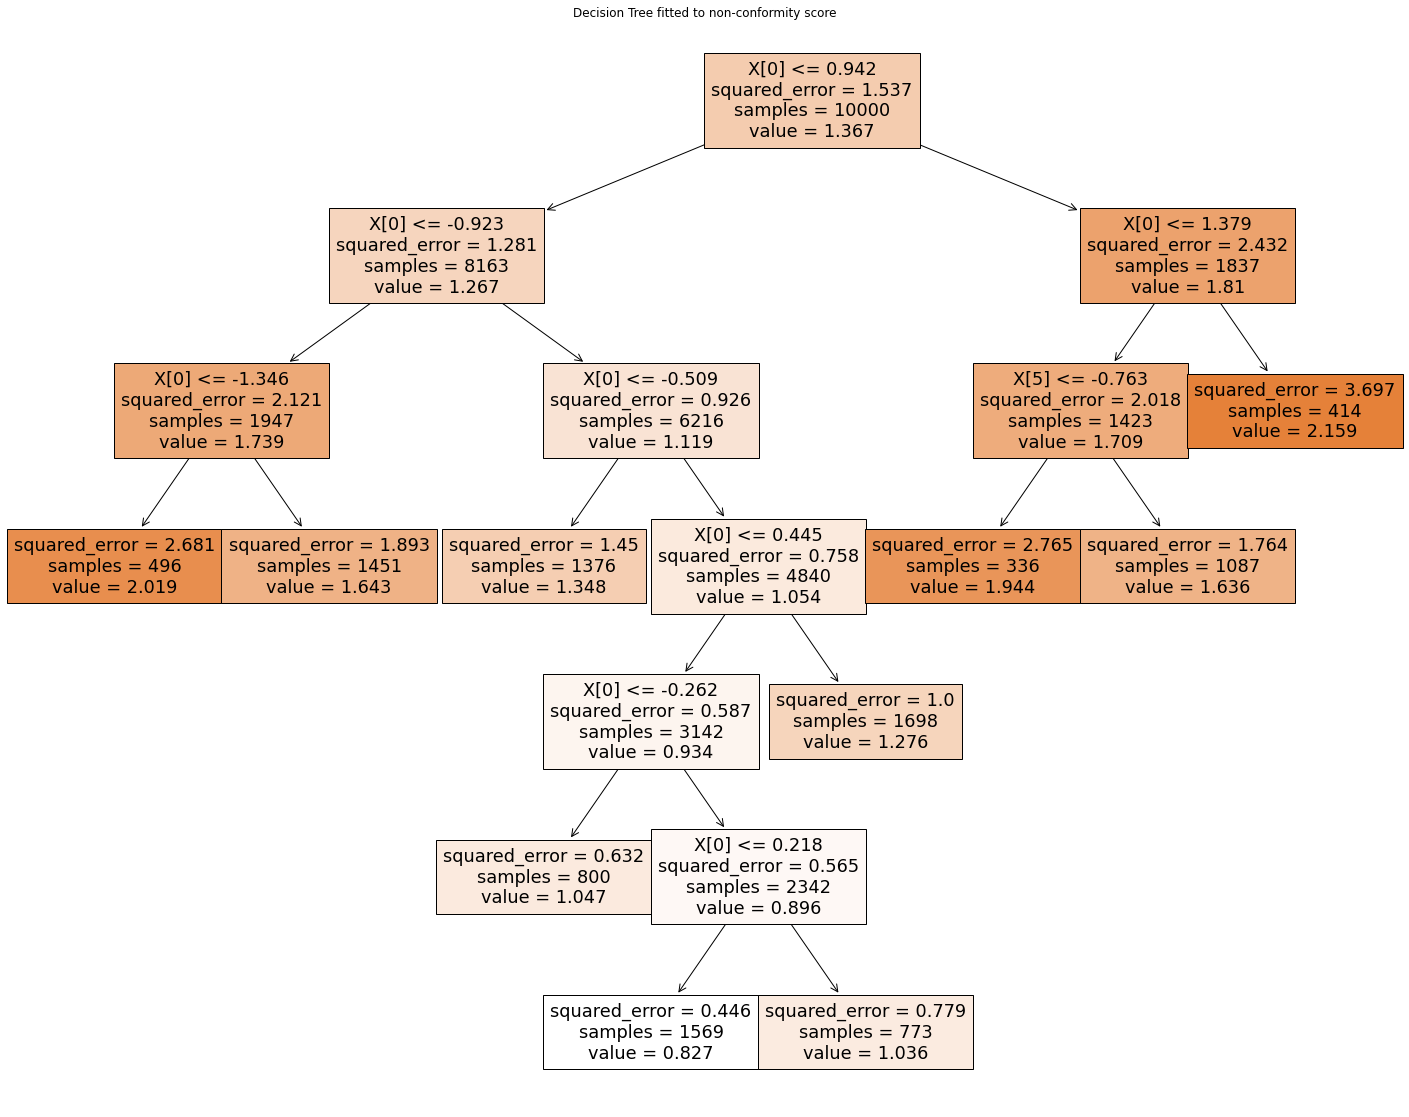

<Figure size 432x288 with 0 Axes>

In [14]:
values_asym = compute_conformal_statistics(kind = "asymmetric", d = 20,
figname_tree = "locart_tree_asymmetric_RF_d_20_split.pdf", B_x = 10000, split_calib = False,
asym_value = 0.6, sig = 0.1)

In [15]:
values_asym[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.040638,0.915,0.031,0.900947,5.340318
1,LOCART,0.032238,0.905,0.020,0.892789,5.114110
2,Regresion split,0.061413,0.918,0.051,0.893224,5.408917
3,Weighted regression split,0.047749,0.902,0.036,0.888810,5.176660
4,Euclidean regression split,0.062057,0.917,0.052,0.892323,5.400602


Now taking $\eta = 1.5$:

Fitting locluster
Computing metrics
Time Elapsed to compute metrics for Locluster:  284.46304392814636
Fitting locart
Time Elapsed to fit Locart:  33.96028017997742
Computing metrics
Time Elapsed to compute metrics for Locart:  166.22509765625
Fitting regression split
Time Elapsed to fit regression split:  36.08604121208191
Computing metrics
Time Elapsed to compute statistics for regression split:  0.9283335208892822
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  55.40564727783203
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  1.988882064819336
Fitting euclidean regression split
Time Elapsed to fit euclidean regression split:  0.5968263149261475
Computing metrics
Time Elapsed to compute statistics for euclidean regression split:  141.90246510505676


<Figure size 720x432 with 0 Axes>

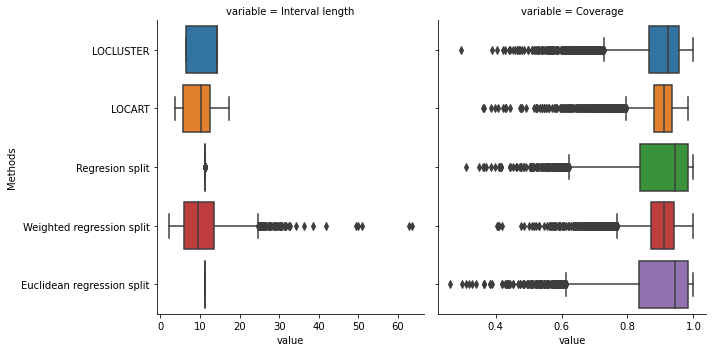

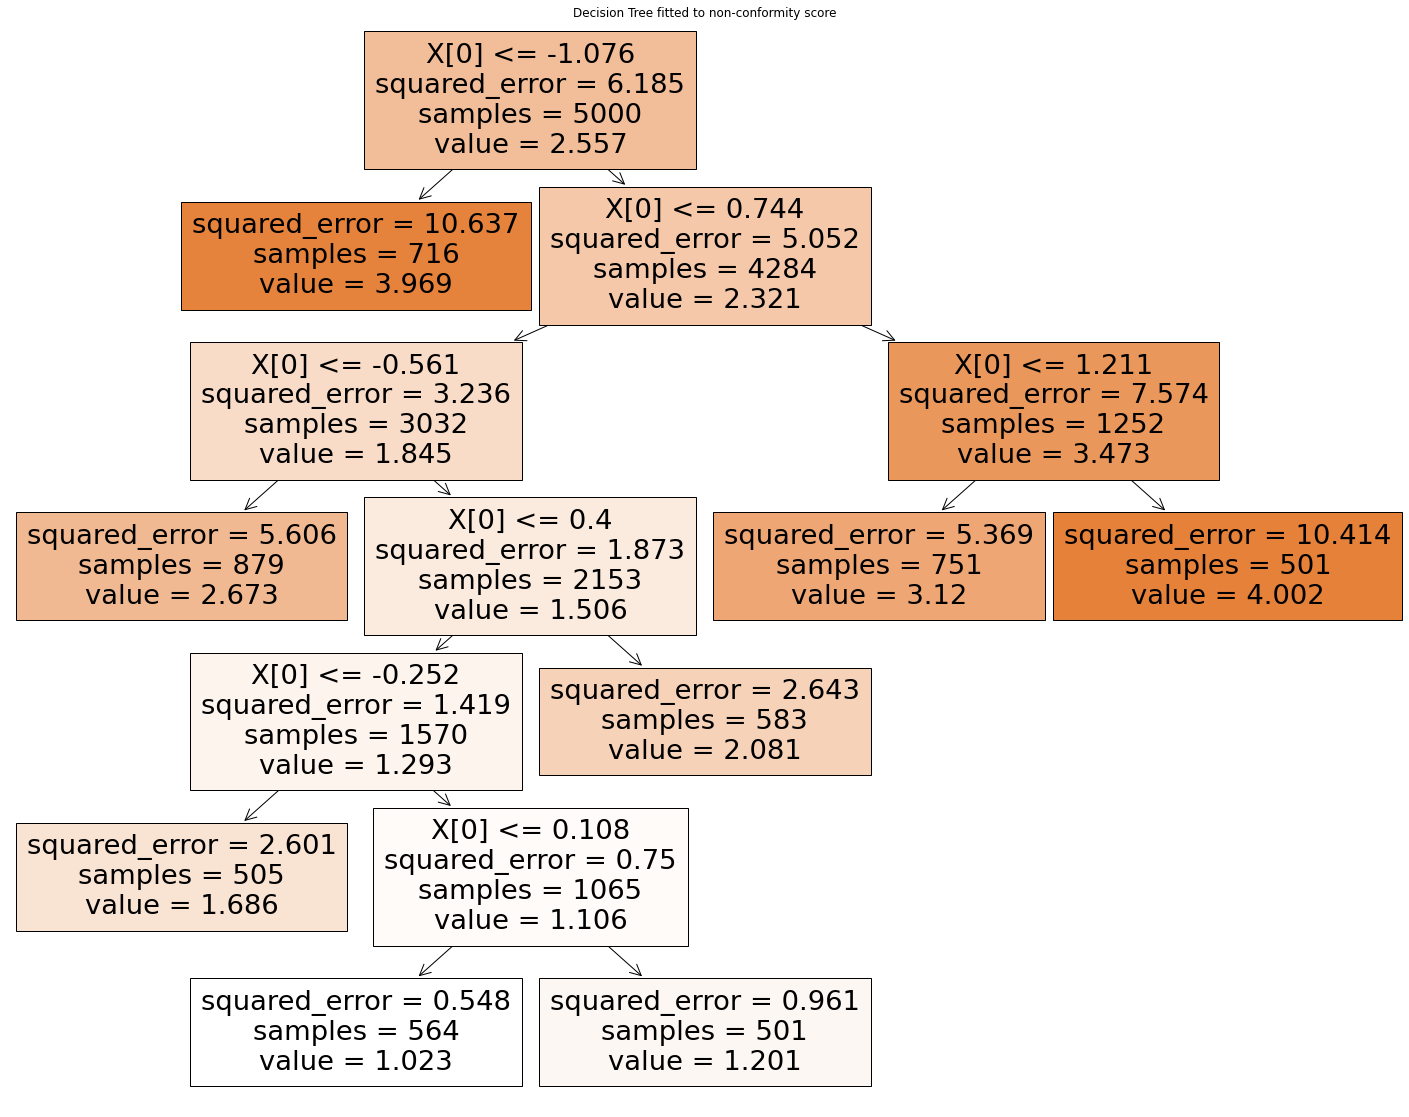

<Figure size 432x288 with 0 Axes>

In [16]:
values_asym = compute_conformal_statistics(kind = "asymmetric", d = 20,
figname_tree = "locart_tree_asymmetric_RF_d_20_eta_1_5_split.pdf", B_x = 10000, split_calib = True,
asym_value = 1.5, sig = 0.1, min_samples_leaf= 500)

In [17]:
values_asym[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.059070,0.9220,0.050,0.899446,10.396351
1,LOCART,0.037636,0.9100,0.030,0.899228,9.952215
2,Regresion split,0.085411,0.9450,0.080,0.900952,11.333233
3,Weighted regression split,0.045872,0.9110,0.037,0.898337,10.124140
4,Euclidean regression split,0.086453,0.9435,0.080,0.899155,11.247800


### Homoscedastic t distribution

taking $\nu = 4$

Fitting locluster
Computing metrics
Time Elapsed to compute metrics for Locluster:  183.22179889678955
Fitting locart
Time Elapsed to fit Locart:  30.366517305374146
Computing metrics
Time Elapsed to compute metrics for Locart:  160.92472863197327
Fitting regression split
Time Elapsed to fit regression split:  31.038913011550903
Computing metrics
Time Elapsed to compute statistics for regression split:  0.7423715591430664
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  49.984636545181274
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  1.75722074508667
Fitting euclidean regression split
Time Elapsed to fit euclidean regression split:  0.5774736404418945
Computing metrics
Time Elapsed to compute statistics for euclidean regression split:  148.05997323989868


<Figure size 720x432 with 0 Axes>

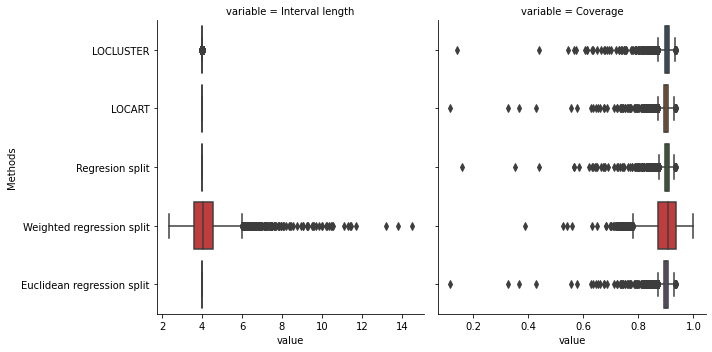

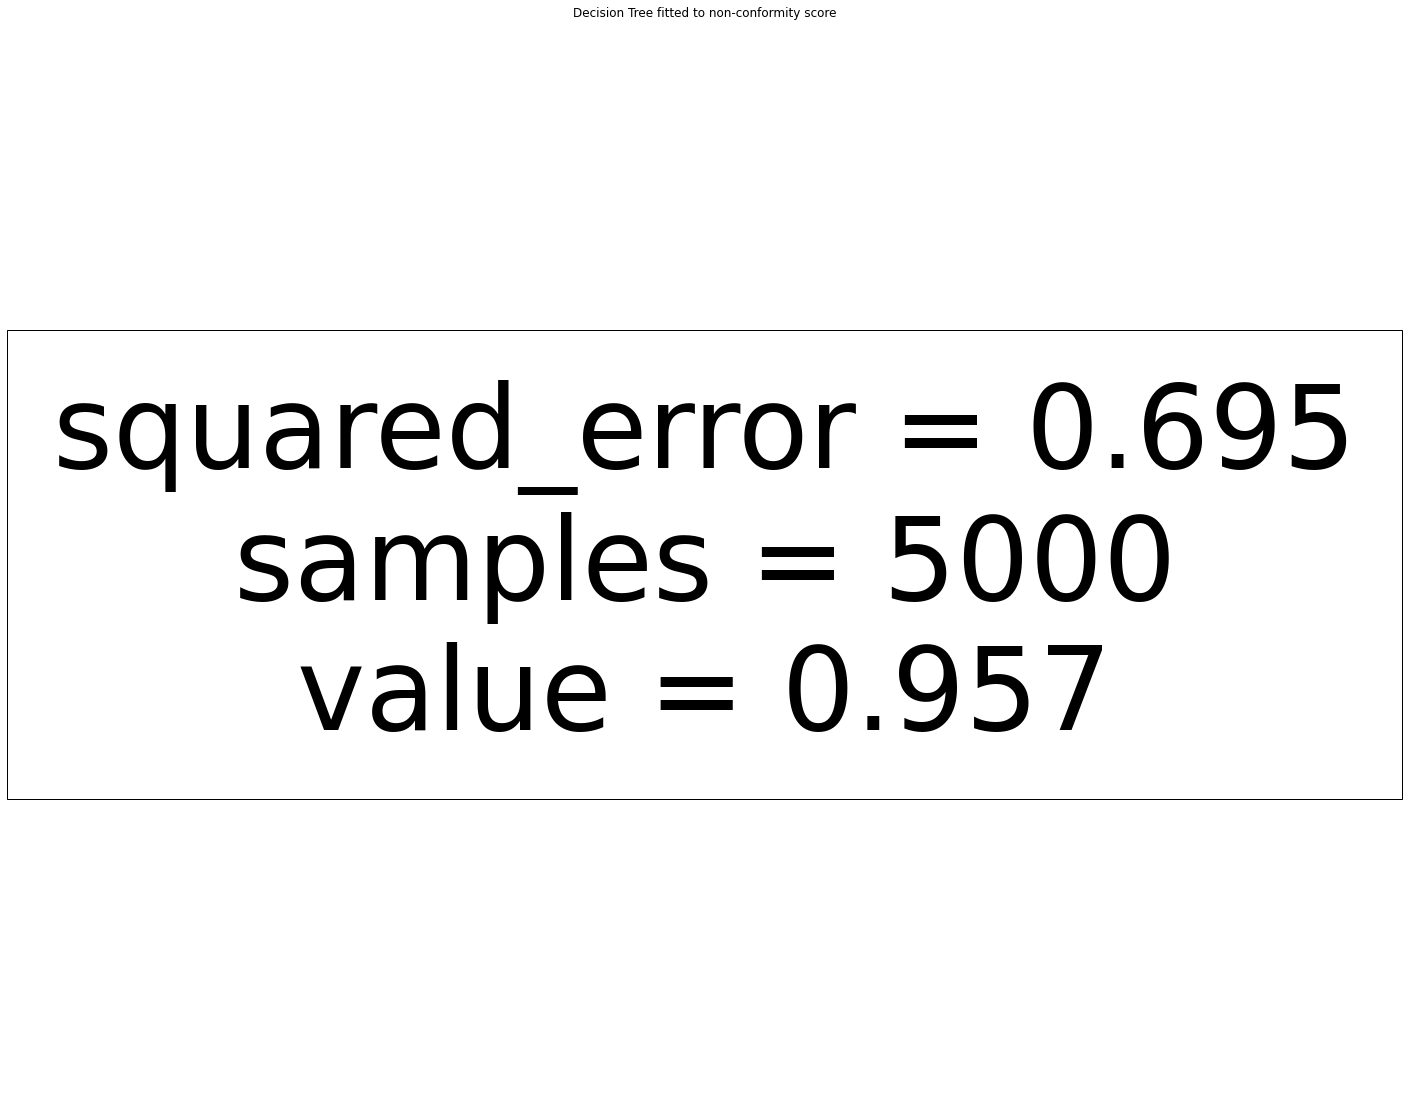

<Figure size 432x288 with 0 Axes>

In [18]:
values_t= compute_conformal_statistics(kind = "t_residuals", d = 20, t_degree= 6,
figname_tree = "locart_tree_asymmetric_RF_d_20_eta_1_5_split.pdf", B_x = 10000, split_calib = True, sig = 0.1)

In [19]:
values_t[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.011046,0.903,0.008,0.900578,3.994613
1,LOCART,0.010756,0.902,0.008,0.900061,3.983571
2,Regresion split,0.010759,0.904,0.008,0.901205,4.000012
3,Weighted regression split,0.037413,0.906,0.032,0.900442,4.167791
4,Euclidean regression split,0.010755,0.902,0.008,0.900054,3.983473


Decreasing $\nu$ to 1.5:

Fitting locluster
Computing metrics
Time Elapsed to compute metrics for Locluster:  249.20724272727966
Fitting locart
Time Elapsed to fit Locart:  44.02572417259216
Computing metrics
Time Elapsed to compute metrics for Locart:  155.58234930038452
Fitting regression split
Time Elapsed to fit regression split:  42.173503398895264
Computing metrics
Time Elapsed to compute statistics for regression split:  0.816068172454834
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  68.63847208023071
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  2.2264132499694824
Fitting euclidean regression split
Time Elapsed to fit euclidean regression split:  0.6666543483734131
Computing metrics
Time Elapsed to compute statistics for euclidean regression split:  155.92978930473328


<Figure size 720x432 with 0 Axes>

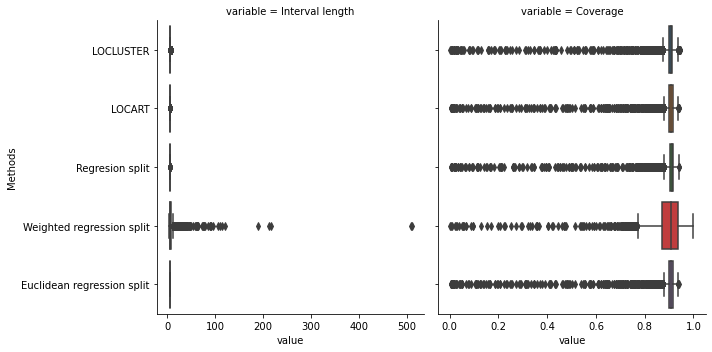

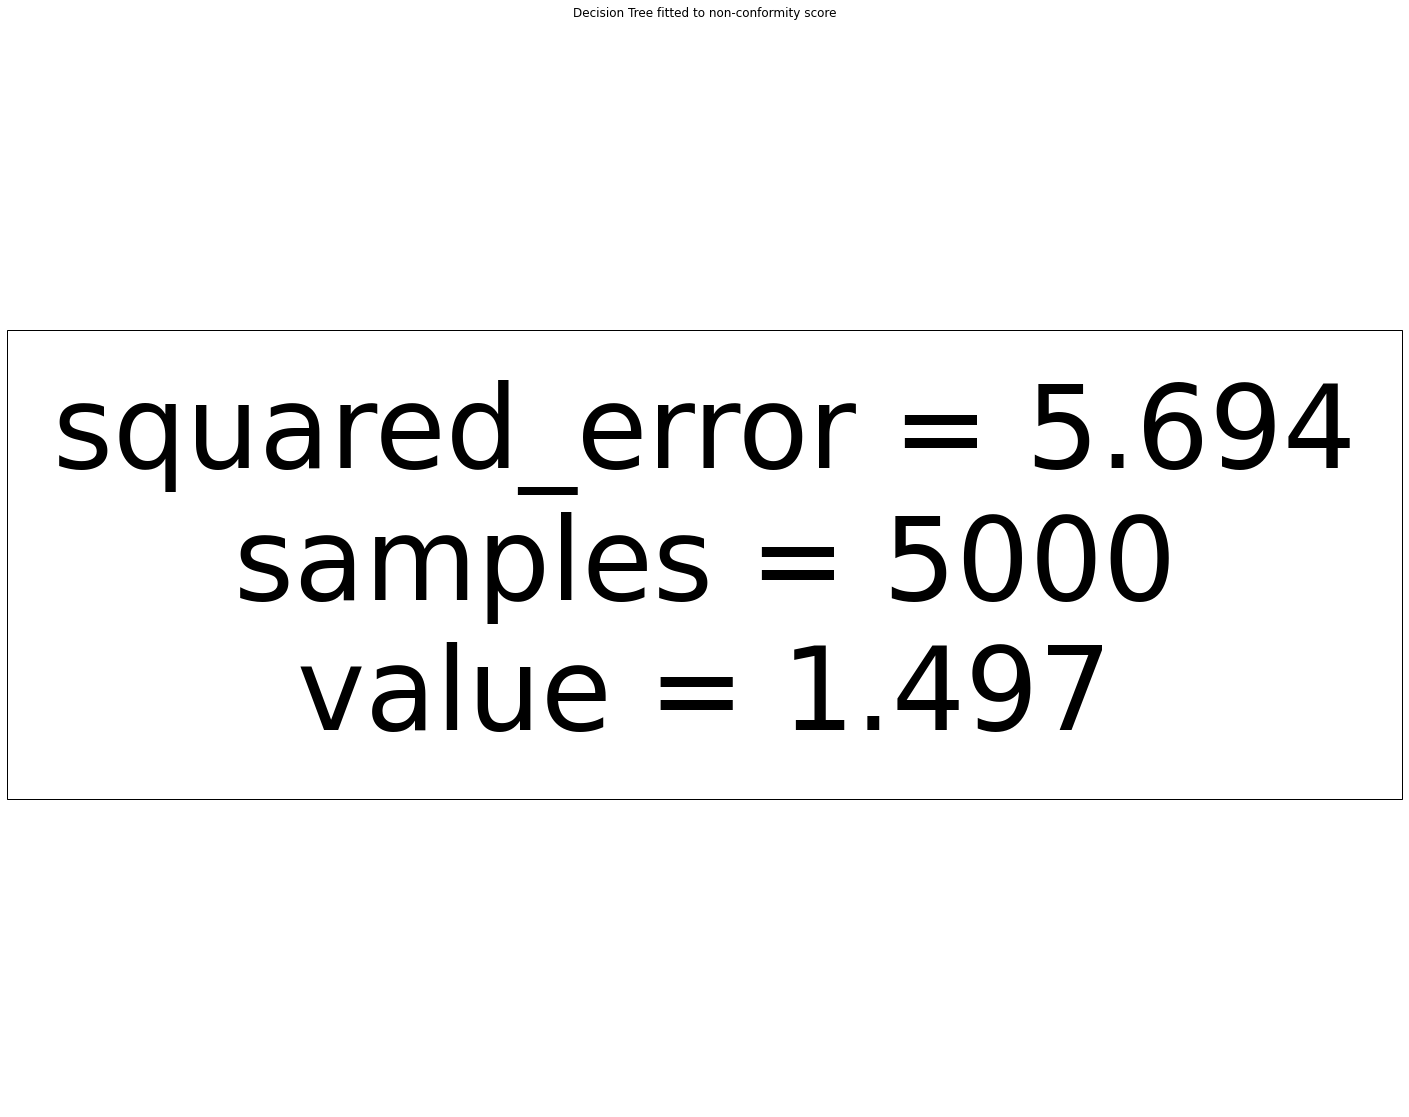

<Figure size 432x288 with 0 Axes>

In [20]:
values_t= compute_conformal_statistics(kind = "t_residuals", d = 20, t_degree= 2,
figname_tree = "locart_tree_asymmetric_RF_d_20_eta_1_5_split.pdf", B_x = 10000, split_calib = True, sig = 0.1)

In [21]:
values_t[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.018879,0.906,0.009,0.896498,6.191357
1,LOCART,0.020806,0.908,0.011,0.897809,6.276656
2,Regresion split,0.021113,0.910,0.012,0.900063,6.335617
3,Weighted regression split,0.042919,0.908,0.034,0.899029,7.423834
4,Euclidean regression split,0.020680,0.908,0.010,0.897294,6.259554


## Weakly correlated heteroscedastic data

Fitting locluster
Computing metrics
Time Elapsed to compute metrics for Locluster:  241.01956033706665
Fitting locart
Time Elapsed to fit Locart:  51.26794171333313
Computing metrics
Time Elapsed to compute metrics for Locart:  155.61886501312256
Fitting regression split
Time Elapsed to fit regression split:  50.09293079376221
Computing metrics
Time Elapsed to compute statistics for regression split:  0.7636170387268066
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  64.97115349769592
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  1.7809486389160156
Fitting euclidean regression split
Time Elapsed to fit euclidean regression split:  0.6201930046081543
Computing metrics
Time Elapsed to compute statistics for euclidean regression split:  156.62070393562317


<Figure size 720x432 with 0 Axes>

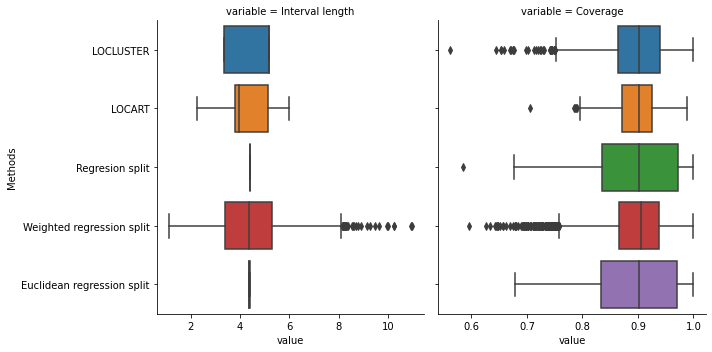

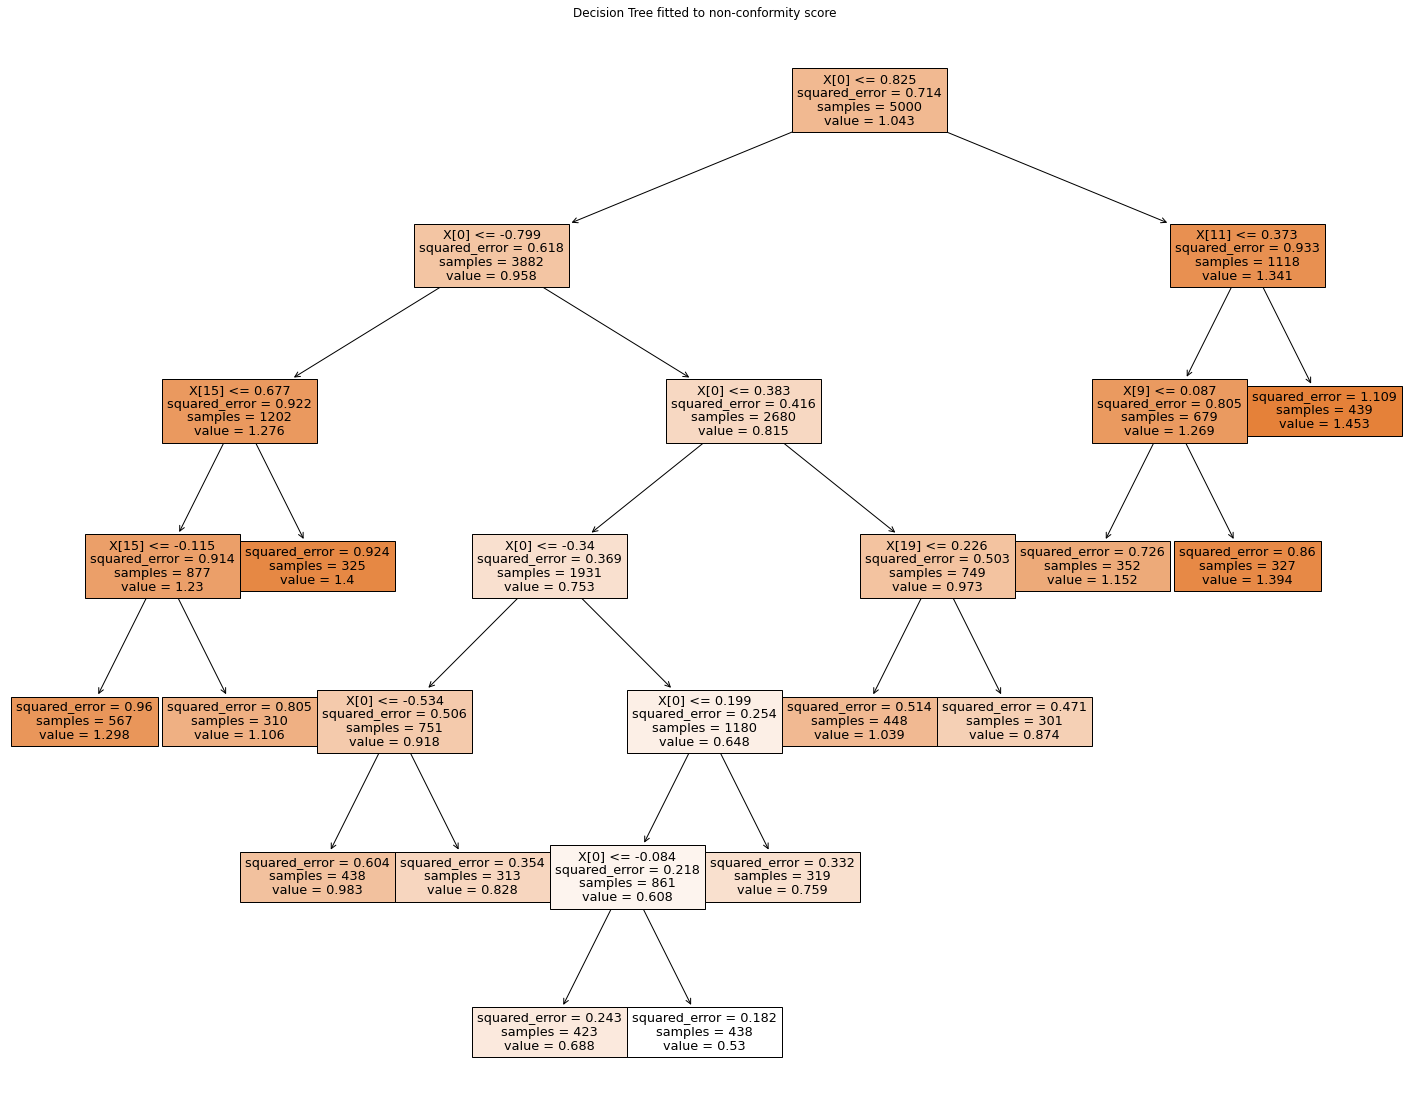

<Figure size 432x288 with 0 Axes>

In [22]:
values = compute_conformal_statistics(kind = "non_cor_heteroscedastic",
d = 20, figname_tree = "locart_tree_non_cor_heteroscedastic_RF_d_20_split.pdf", B_x = 10000, split_calib = True,
hetero_value = 0.25, sig = 0.1)

In [23]:
values[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.043908,0.9020,0.0375,0.901279,4.294948
1,LOCART,0.029391,0.9010,0.0270,0.899084,4.234373
2,Regresion split,0.064694,0.9020,0.0680,0.899719,4.403914
3,Weighted regression split,0.043450,0.9055,0.0370,0.897563,4.337303
4,Euclidean regression split,0.065485,0.9010,0.0690,0.898036,4.379793


### Quantilic score

We now change the score to the quantilic one, and compare our methods to cqr and raw quantilic regression:

#### Homoscedastic:

<Figure size 720x432 with 0 Axes>

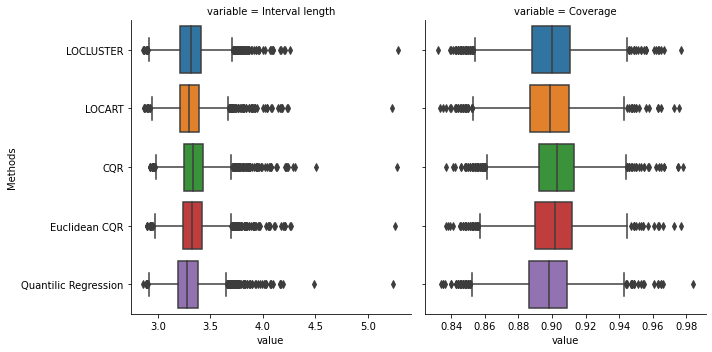

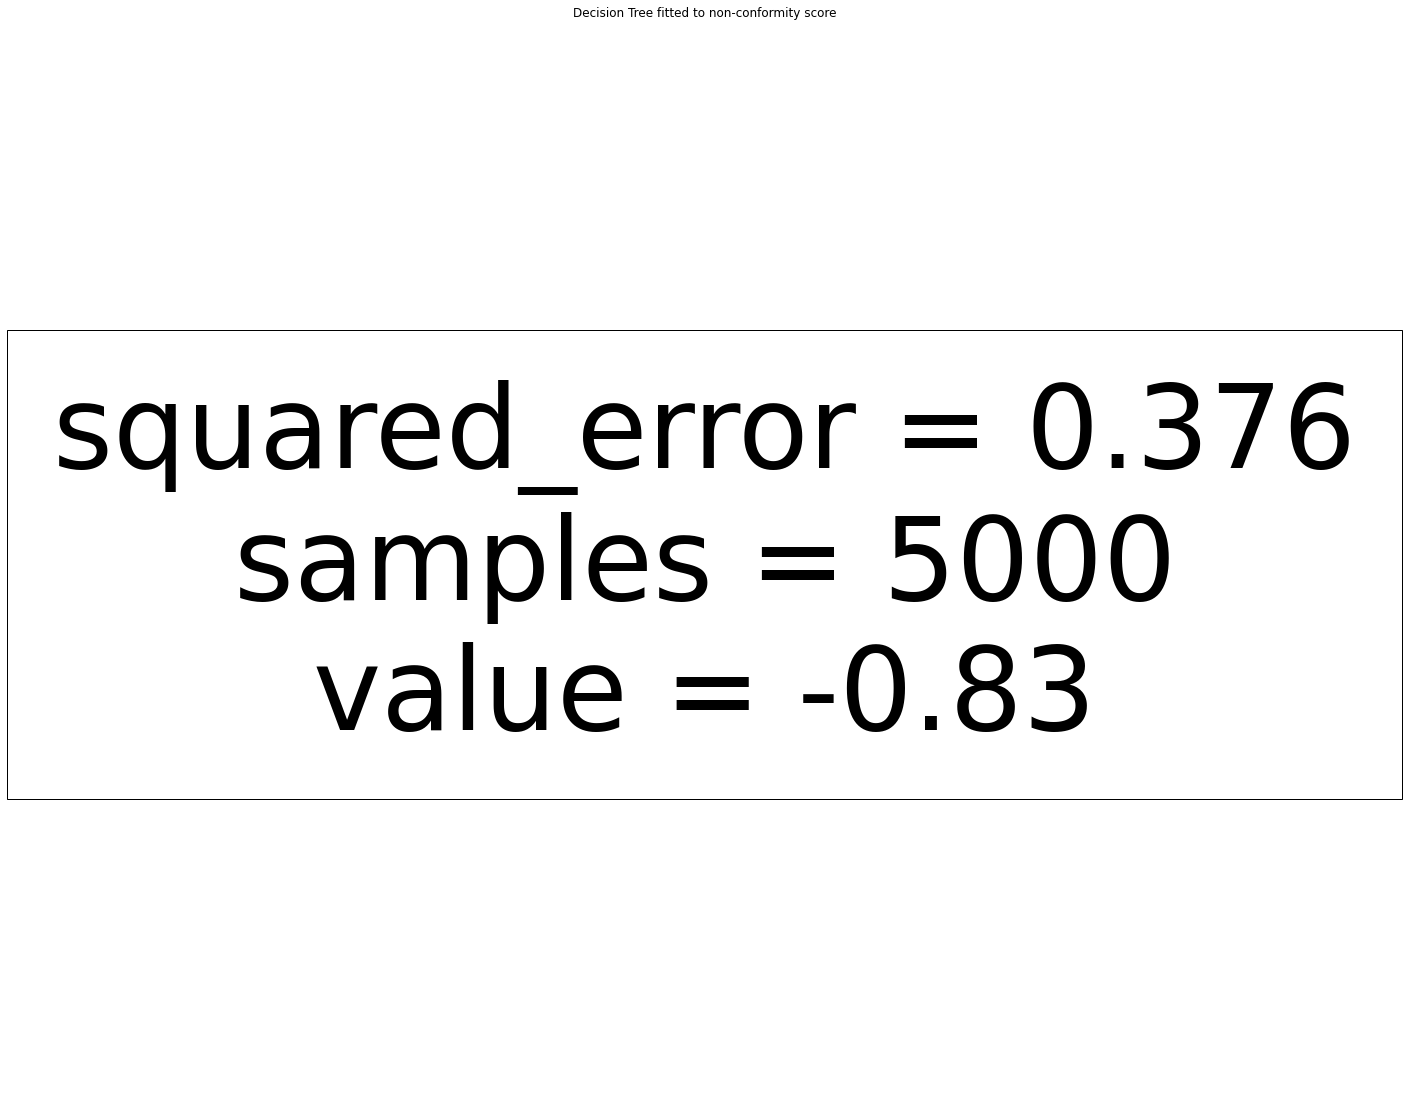

<Figure size 432x288 with 0 Axes>

In [32]:
locart_cov_values = compute_conformal_statistics(figname_tree = "locart_tree_homoscedastic_RF_d_20.pdf",
type_score = "quantile", base_model = QuantileGradientBoosting,
split_calib = True, B_x = 10000, sig  = 0.1)

In [33]:
locart_cov_values[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.013912,0.900,0.012,0.898978,3.307707
1,LOCART,0.013377,0.899,0.011,0.898072,3.299197
2,CQR,0.013122,0.903,0.011,0.902151,3.339257
3,Euclidean CQR,0.013114,0.902,0.011,0.900818,3.325852
4,Quantilic Regression,0.013705,0.898,0.011,0.896810,3.287052


#### Heteroscedastic

<Figure size 720x432 with 0 Axes>

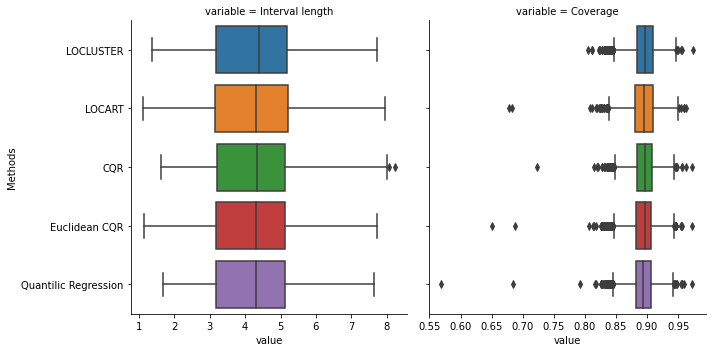

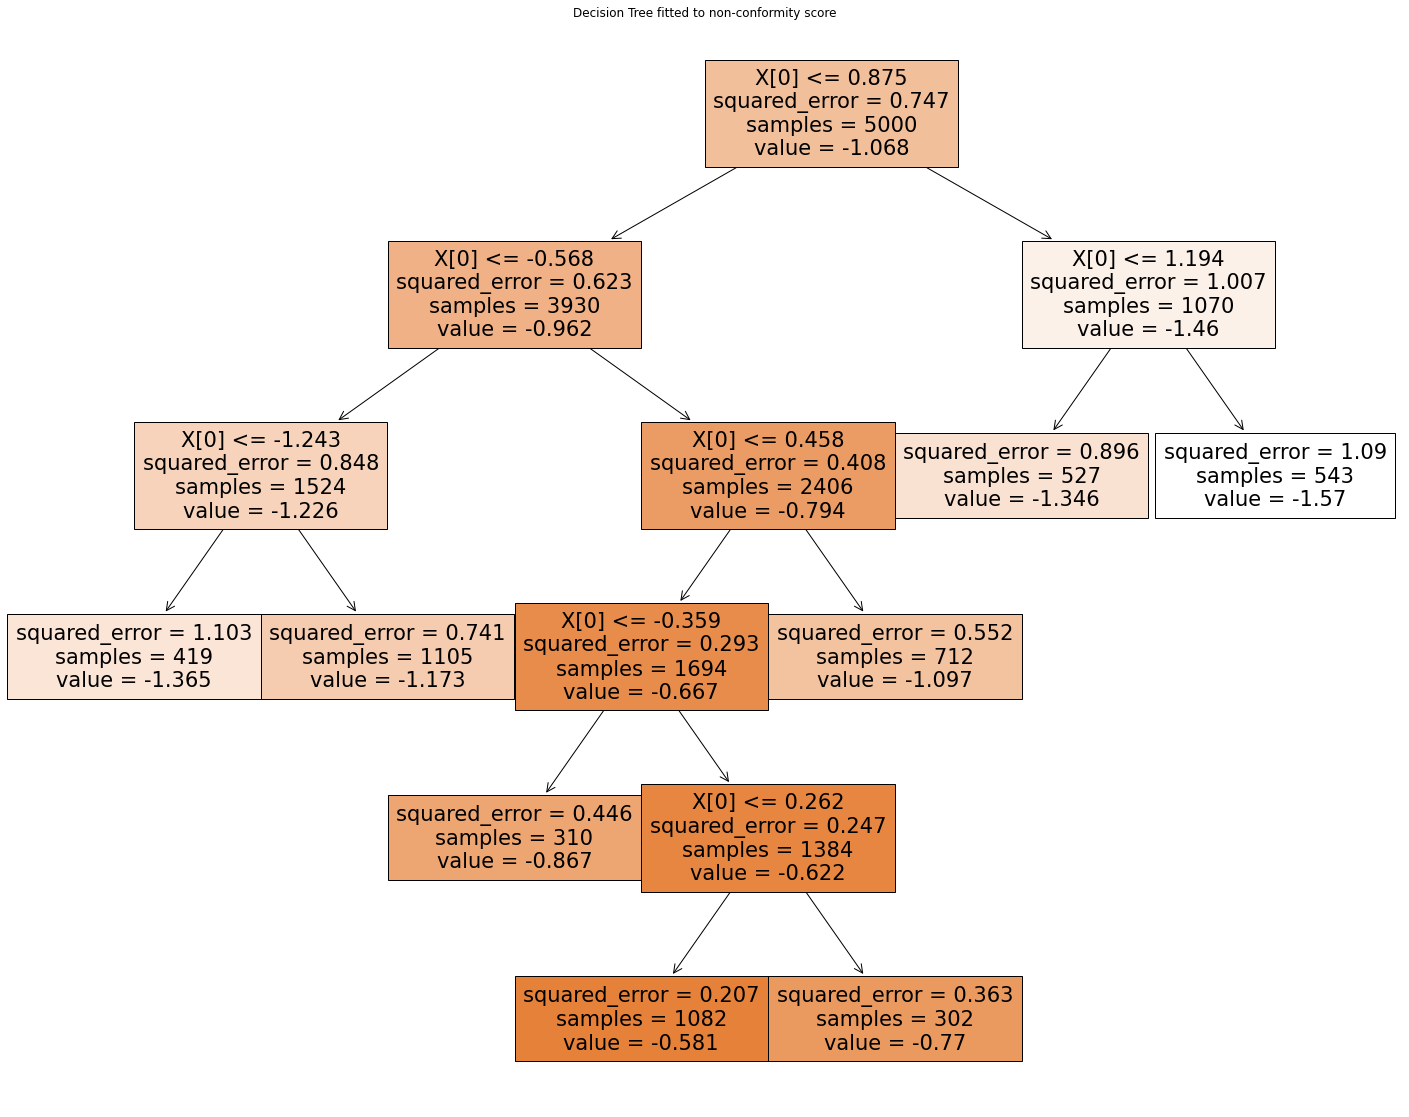

<Figure size 432x288 with 0 Axes>

In [58]:
heteroscedastic_values = compute_conformal_statistics(kind = "heteroscedastic", d = 30,
figname_tree = "locart_tree_heteroscedastic_RF_d_20_split.pdf", B_x = 10000,
split_calib = True,
type_score = "quantile", base_model = QuantileGradientBoosting,
hetero_value = 0.25, sig = 0.1)

In [56]:
heteroscedastic_values[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.012881,0.899,0.011,0.898774,4.531393
1,LOCART,0.015208,0.901,0.012,0.899324,4.525812
2,CQR,0.012841,0.903,0.011,0.902822,4.586247
3,Euclidean CQR,0.012502,0.902,0.010,0.901444,4.568772
4,Quantilic Regression,0.013063,0.898,0.011,0.897945,4.524989


Another heteroscedastic:

<Figure size 720x432 with 0 Axes>

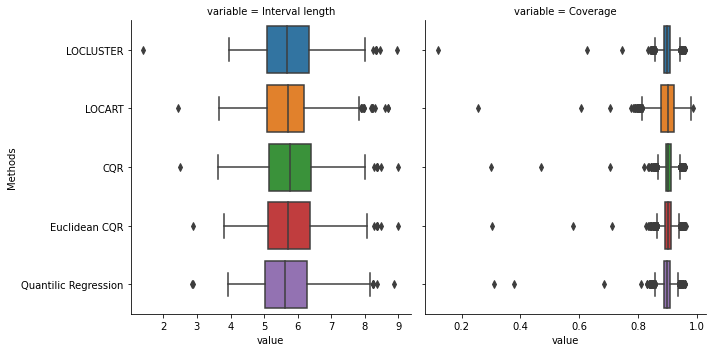

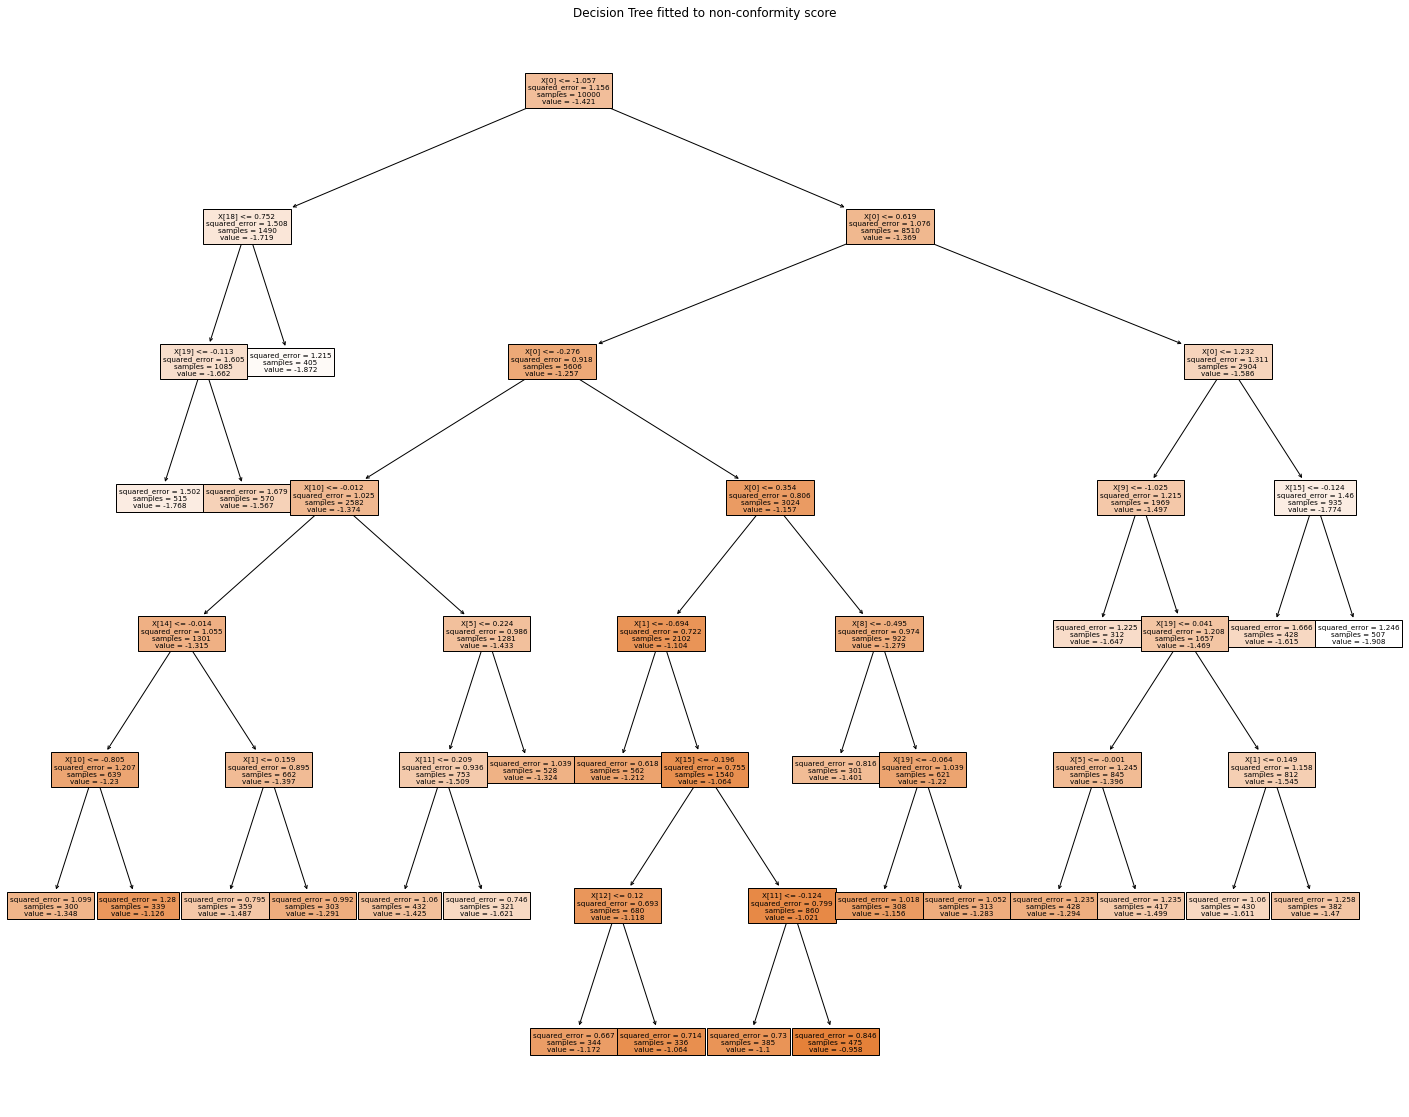

<Figure size 432x288 with 0 Axes>

In [45]:
heteroscedastic_values = compute_conformal_statistics(kind = "heteroscedastic", d = 20,
figname_tree = "locart_tree_heteroscedastic_RF_d_20_split.pdf", B_x = 10000,
split_calib = True,
type_score = "quantile", base_model = QuantileGradientBoosting,
hetero_value = 1.5, sig = 0.1)

In [46]:
heteroscedastic_values[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.012166,0.8995,0.010,0.899450,5.653333
1,LOCART,0.025259,0.9020,0.021,0.897848,5.659038
2,CQR,0.012316,0.9030,0.010,0.903325,5.716751
3,Euclidean CQR,0.012244,0.9020,0.010,0.902466,5.702911
4,Quantilic Regression,0.012699,0.8970,0.011,0.896867,5.611204


<Figure size 720x432 with 0 Axes>

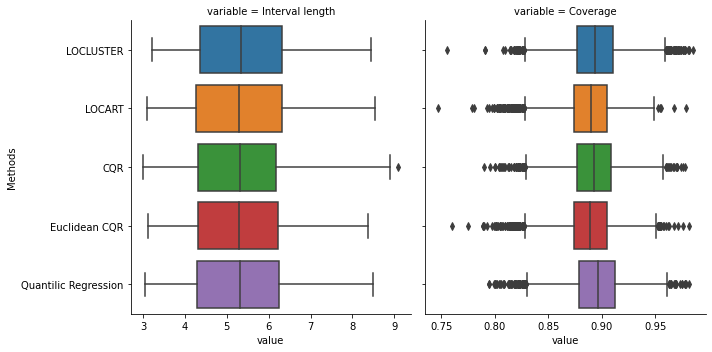

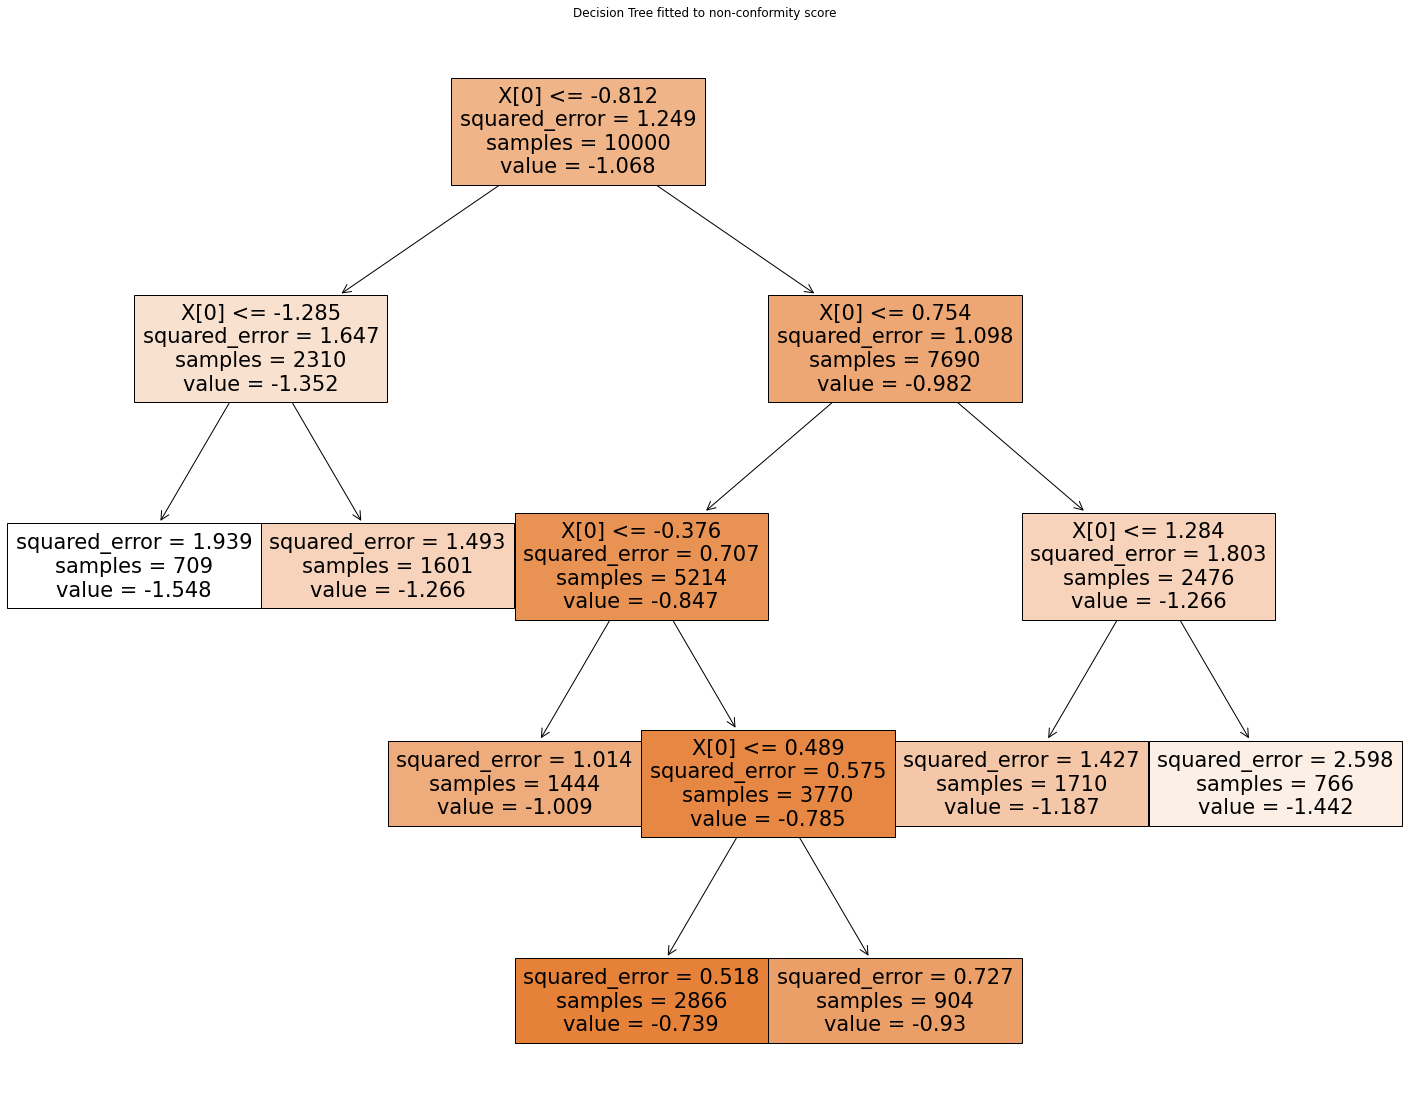

<Figure size 432x288 with 0 Axes>

In [39]:
heteroscedastic_values = compute_conformal_statistics(kind = "asymmetric", d = 20,
figname_tree = "locart_tree_heteroscedastic_RF_d_20_split.pdf", B_x = 10000, split_calib = False,
asym_value = 0.6, type_score = "quantile", base_model = QuantileGradientBoosting,
 sig = 0.1)

In [40]:
heteroscedastic_values[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.020074,0.894,0.017,0.894048,5.334672
1,LOCART,0.020080,0.890,0.016,0.888505,5.338443
2,CQR,0.019678,0.893,0.017,0.893084,5.318134
3,Euclidean CQR,0.020553,0.889,0.017,0.888889,5.307629
4,Quantilic Regression,0.019704,0.896,0.017,0.895044,5.323314


<Figure size 720x432 with 0 Axes>

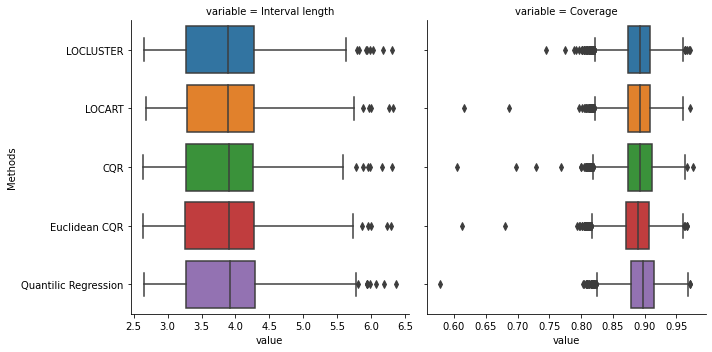

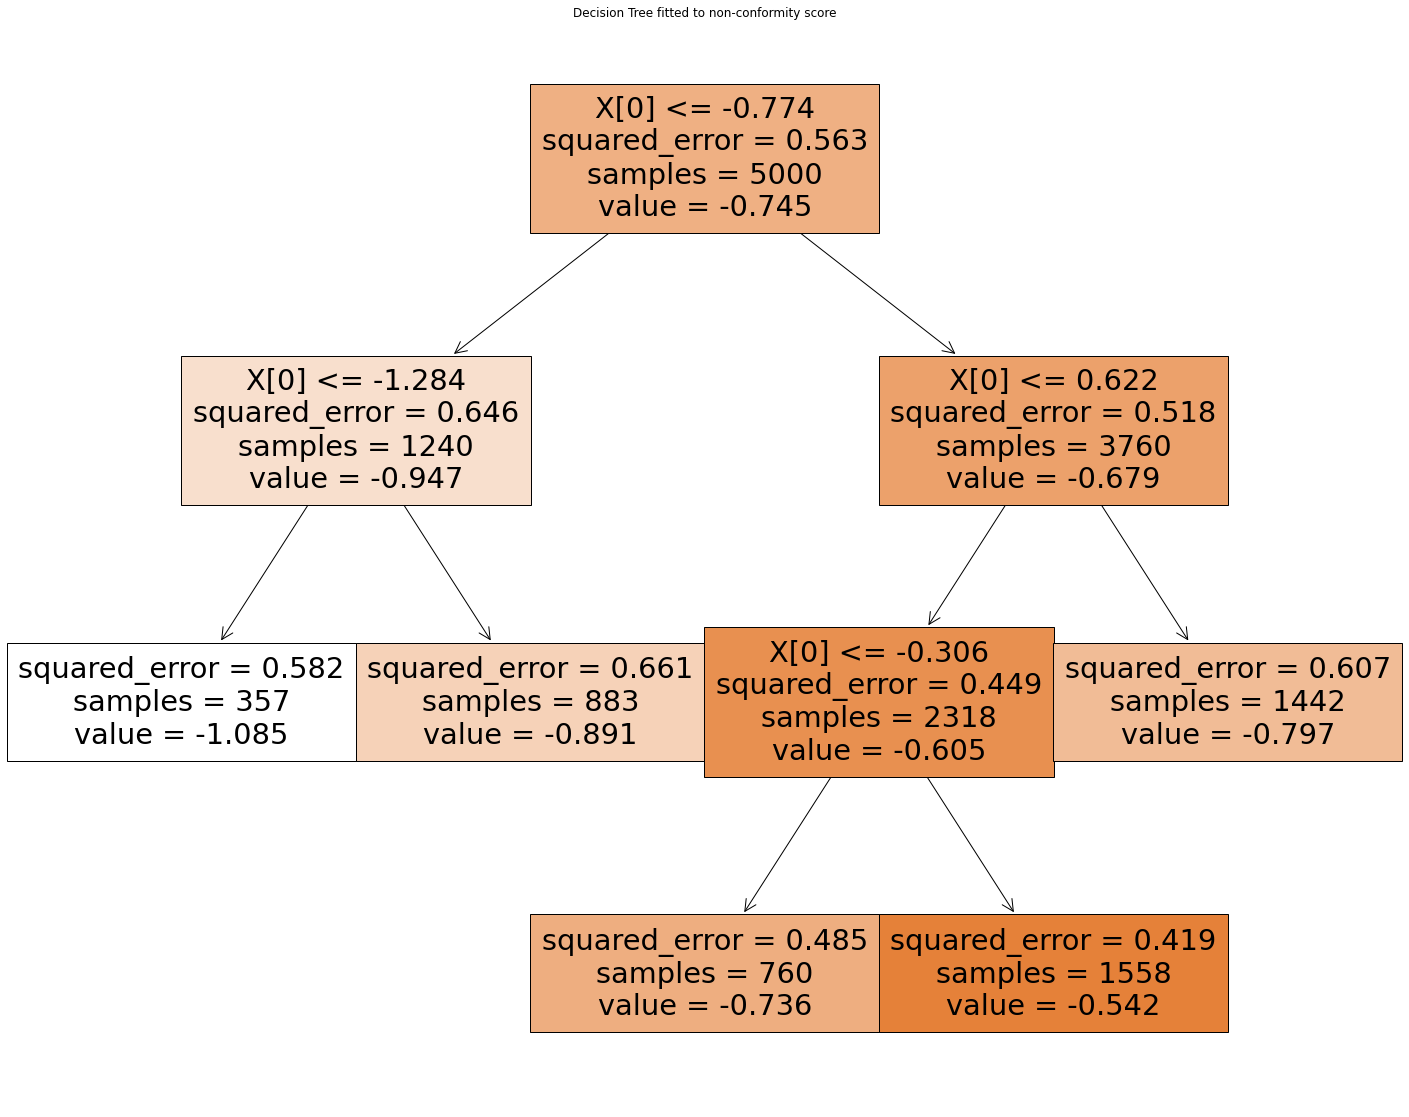

<Figure size 432x288 with 0 Axes>

In [48]:
heteroscedastic_values = compute_conformal_statistics(kind = "asymmetric", d = 20,
figname_tree = "locart_tree_heteroscedastic_RF_d_20_split.pdf", B_x = 10000, split_calib = True,
asym_value = 0.25, type_score = "quantile", base_model = QuantileGradientBoosting,
 sig = 0.1)

In [49]:
heteroscedastic_values[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.021996,0.892,0.018,0.890817,3.886585
1,LOCART,0.021196,0.892,0.018,0.890878,3.886924
2,CQR,0.022125,0.893,0.019,0.892076,3.889990
3,Euclidean CQR,0.023044,0.890,0.019,0.888572,3.883005
4,Quantilic Regression,0.021095,0.897,0.018,0.896317,3.907150


<Figure size 720x432 with 0 Axes>

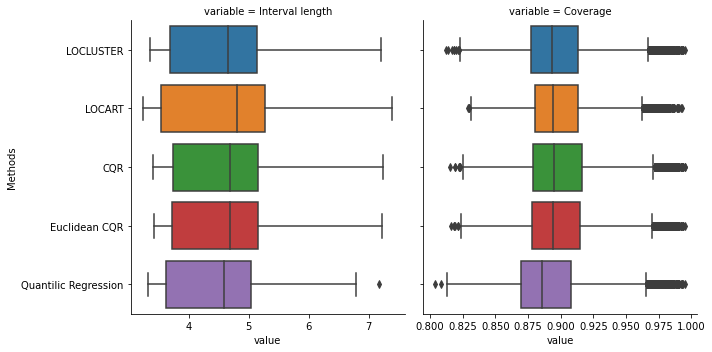

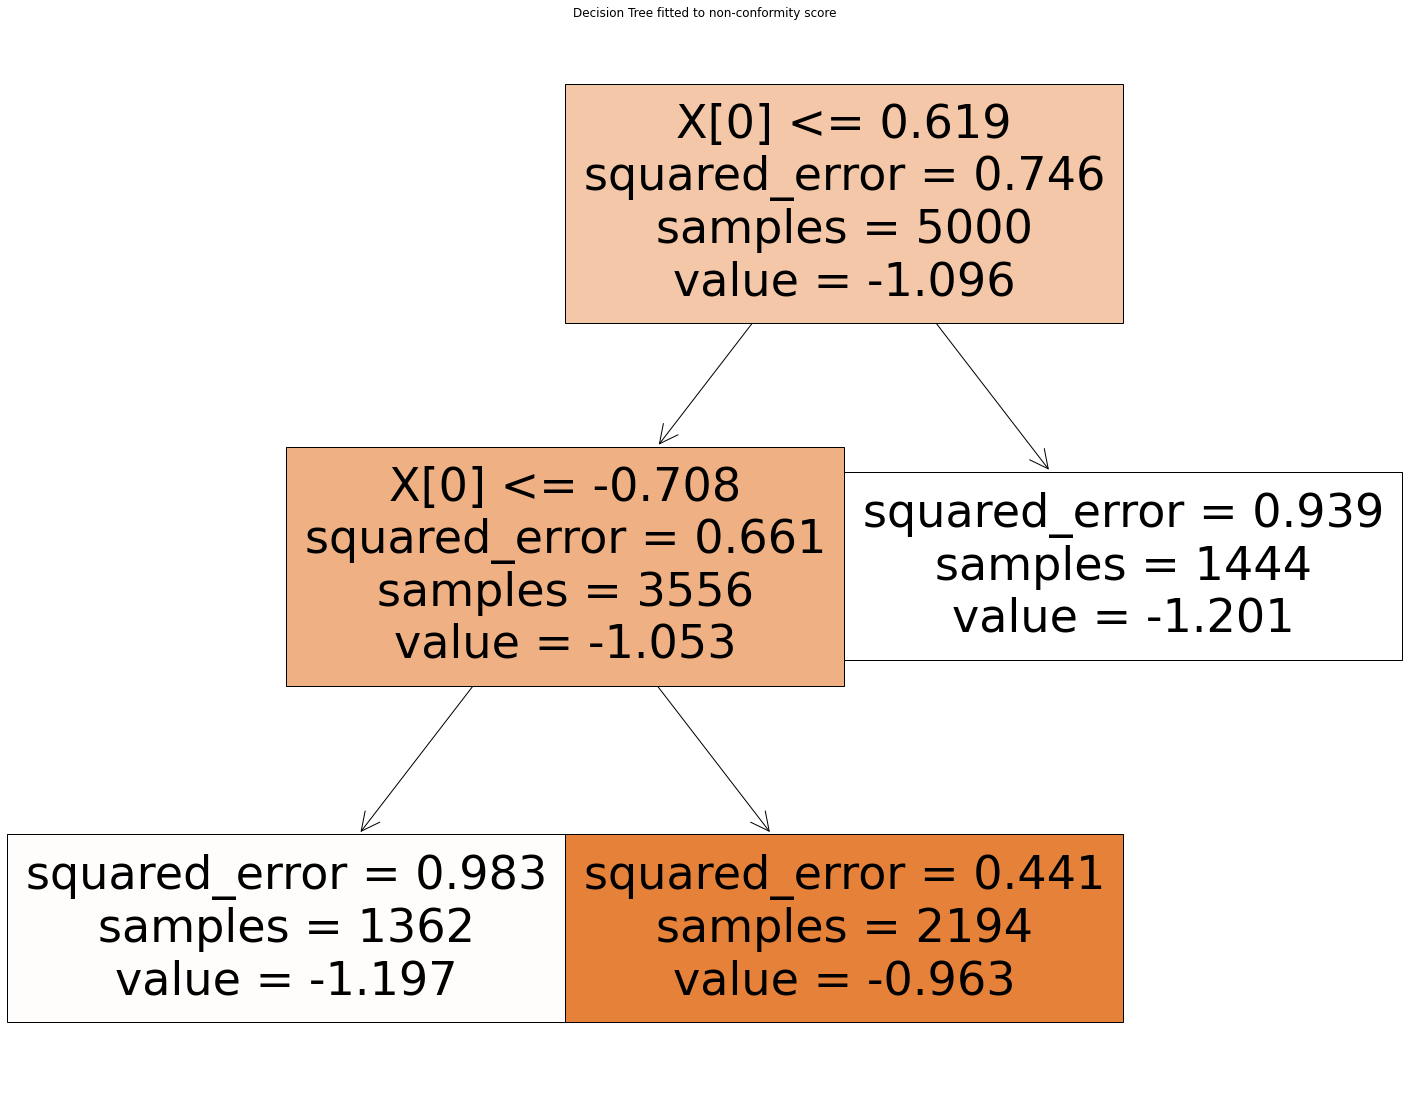

<Figure size 432x288 with 0 Axes>

In [52]:
values = compute_conformal_statistics(kind = "non_cor_heteroscedastic",
d = 20, figname_tree = "locart_tree_non_cor_heteroscedastic_RF_d_20_split.pdf", B_x = 10000, split_calib = True,
 type_score = "quantile", base_model = QuantileGradientBoosting,
hetero_value = 0.5, sig = 0.1)

In [53]:
values[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.025560,0.893,0.020,0.898856,4.485116
1,LOCART,0.021979,0.894,0.017,0.899325,4.501993
2,CQR,0.025067,0.895,0.019,0.900971,4.514304
3,Euclidean CQR,0.025336,0.894,0.019,0.899910,4.499683
4,Quantilic Regression,0.028151,0.886,0.024,0.893160,4.410385
